In [1]:
import pickle
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.image as img 

import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import gc
from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import load_dataset, get_Z_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.tools import weights_init_D
from src.plotters import plot_random_Z_images, plot_Z_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb
from src.tools import fig2data, fig2img # for wandb
from torch.utils.data import Dataset, Subset
# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
import matplotlib.image as mpimg
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from src.distributions import LoaderSampler
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

In [2]:
wandb.login(key = "4fdc80081f697423f86ffc96872a32c567050a8a", relogin = True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: danymost04 (danymost04-cole-normale-sup-rieure-paris-saclay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Colorization

In [29]:
DEVICE_IDS = [0]

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64
ZC = 1
Z_STD = 0.1
Z_SIZE = 8
BATCH_SIZE = 64

PLOT_INTERVAL = 100
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 2000
MAX_STEPS = 5000
SEED = 0x000000
GAMMA0, GAMMA1 = 0.0, 0.66
GAMMA_ITERS = 2500

DATASET1 = "DesertGray"
DATASET2 = "DesertColored"
EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}'
OUTPUT_PATH = '../checkpoints/{}/{}_{}_{}/'.format(COST, DATASET1, DATASET2, IMG_SIZE)
DEVICE = "cuda"

## Preparation

In [18]:
config = dict(
    DATASET1 = DATASET1,
    DATASET2 = DATASET2,
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

## Prepare Samplers (X, Y)

In [19]:

class DesertDataset(Dataset):
    def __init__(self, grayscale = True):
        
        super().__init__()
        X = []
        dataset_dir = "../datasets/colorization/"
        if grayscale:
            self.transforms =  transforms.Compose([
            transforms.ToTensor(),  
            transforms.Resize((64, 64)),  # Ensure correct size
                  # Convert to tensor
           
            torchvision.transforms.Grayscale(num_output_channels=3),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        else:
            
            self.transforms = transforms.Compose([
            transforms.ToTensor(),  
            transforms.Resize((64, 64)),  # Ensure correct size
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        ])
        for filename in os.listdir(dataset_dir + "Desert"):
            X_dir = dataset_dir + "Desert"
        
            file_path_X = X_dir + "/" + filename
            if file_path_X.split(".")[-1] == "jpeg":
                imgX = mpimg.imread(file_path_X)
                X.append(self.transforms(np.array(imgX)))
        self.X = X

        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], 0

In [20]:
dataset_X = DesertDataset(True)
dataset_Y = DesertDataset(False)

In [21]:
import numpy as np
np.random.seed(42)
indices = torch.randperm(len(dataset_X)).tolist()
train_size = int(0.9 * len(dataset_X))
train_indices, val_indices = indices[:train_size], indices[train_size:]

# Create subsets using the same indices
train_dataset_X, val_dataset_X, = Subset(dataset_X, train_indices), Subset(dataset_X, val_indices)
train_dataset_Y, val_dataset_Y = Subset(dataset_Y, train_indices), Subset(dataset_Y, val_indices)


In [22]:
X_sampler = LoaderSampler(DataLoader(train_dataset_X, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), DEVICE )
Y_sampler = LoaderSampler(DataLoader(train_dataset_Y, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), DEVICE)
X_test_sampler = LoaderSampler(DataLoader(val_dataset_X, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), DEVICE)
Y_test_sampler = LoaderSampler(DataLoader(val_dataset_Y, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), DEVICE)

# Initializing Networks

In [23]:

f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)
#f.load_state_dict(torch.load("./models/f_1900.pth", weights_only = True))
T = UNet(3+ZC, 3, base_factor=48).cuda() # ZC - noise input channels z
#T.load_state_dict(torch.load("./models/T_1900.pth", weights_only = True))
if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 9716259
f params: 22933441


In [24]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)[:,None].repeat(1,4,1,1,1)
with torch.no_grad():
    Z_fixed = torch.randn(10, 4, ZC, IMG_SIZE, IMG_SIZE, device='cuda') * Z_STD
    XZ_fixed = torch.cat([X_fixed, Z_fixed], dim=2)
del X_fixed, Z_fixed
Y_fixed = Y_sampler.sample(10)

X_test_fixed = X_test_sampler.sample(10)[:,None].repeat(1,4,1,1,1)
with torch.no_grad():
    Z_test_fixed = torch.randn(10, 4, ZC, IMG_SIZE, IMG_SIZE, device='cuda') * Z_STD
    XZ_test_fixed = torch.cat([X_test_fixed, Z_test_fixed], dim=2)
del X_test_fixed, Z_test_fixed
Y_test_fixed = Y_test_sampler.sample(10)

### Plots Test

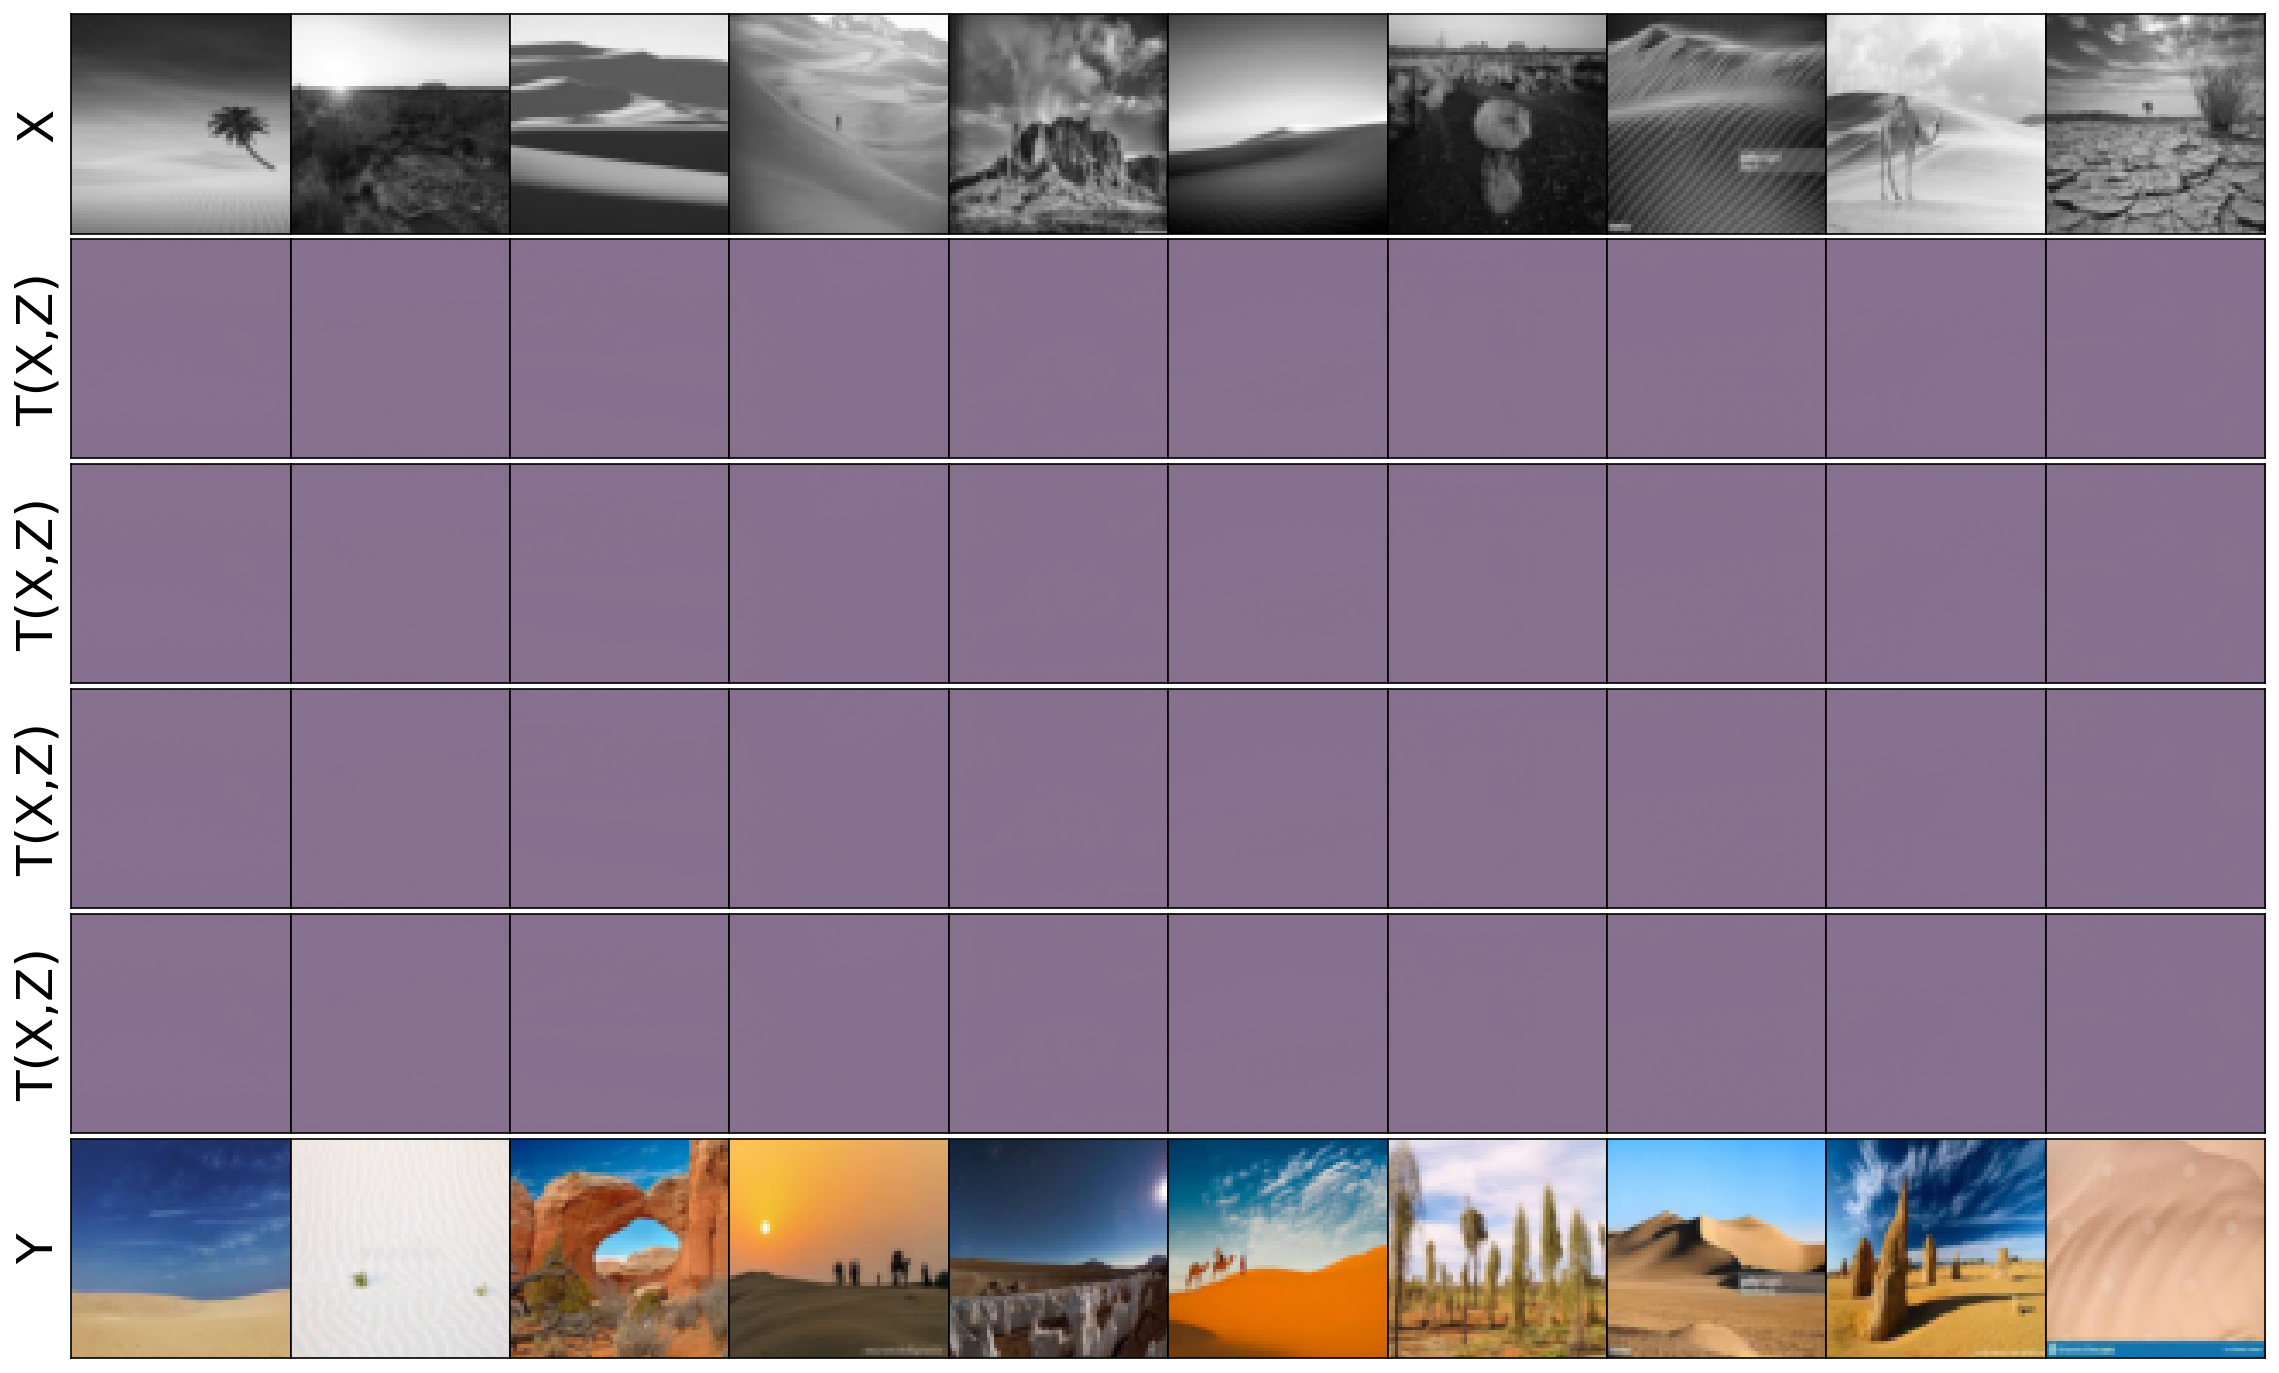

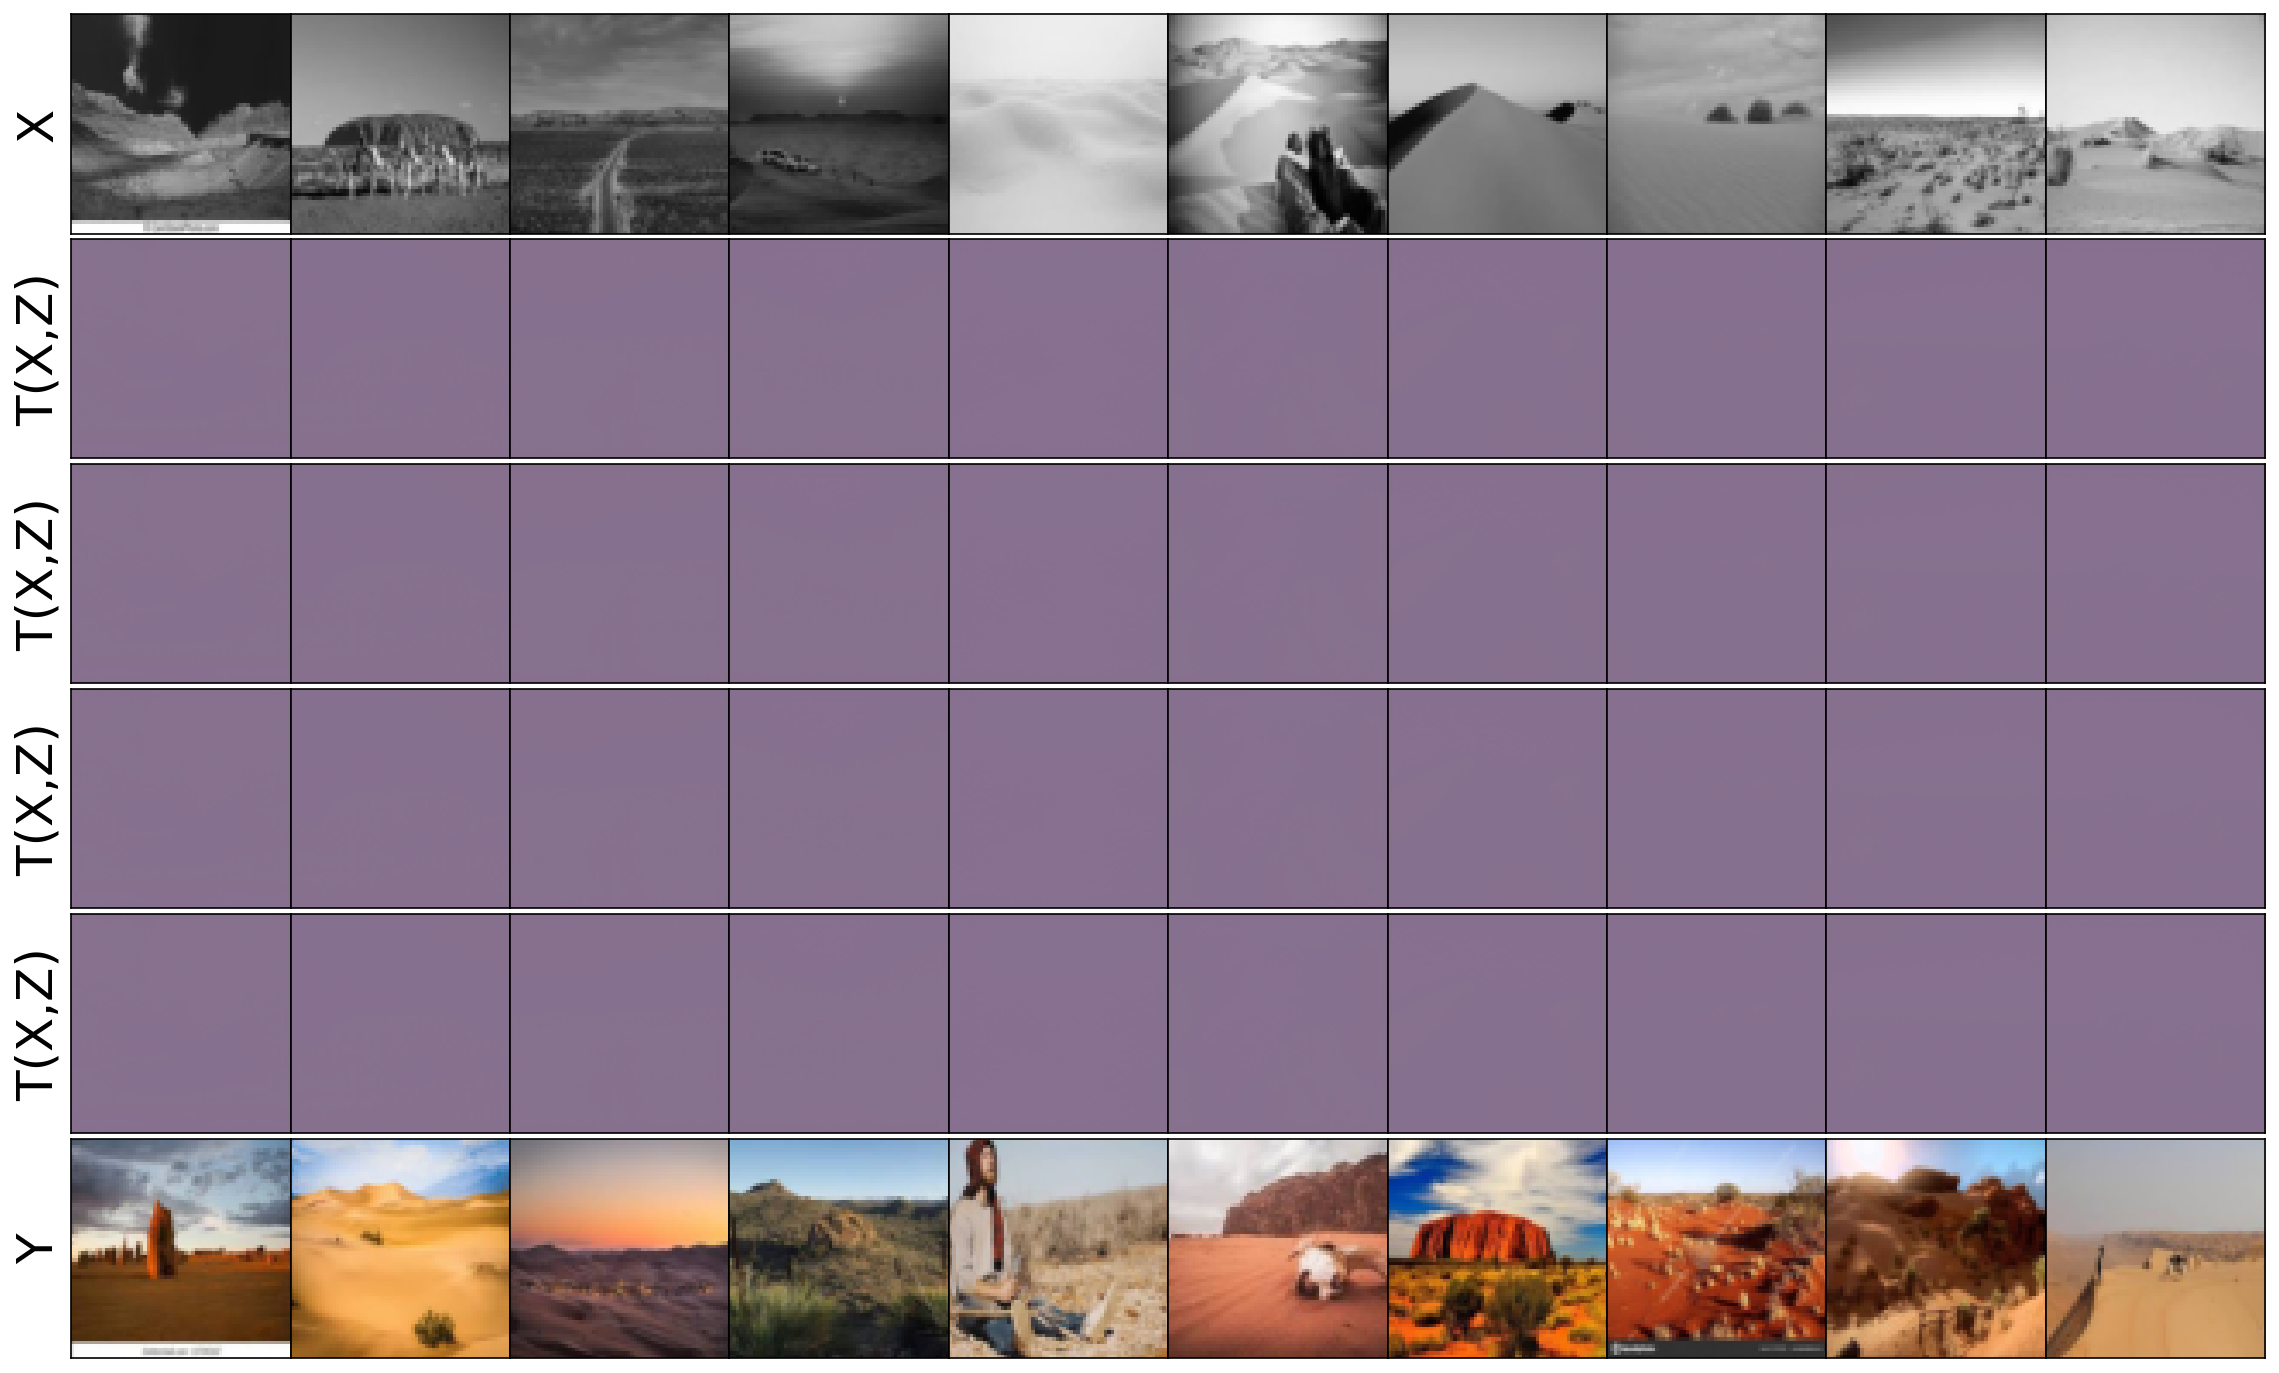

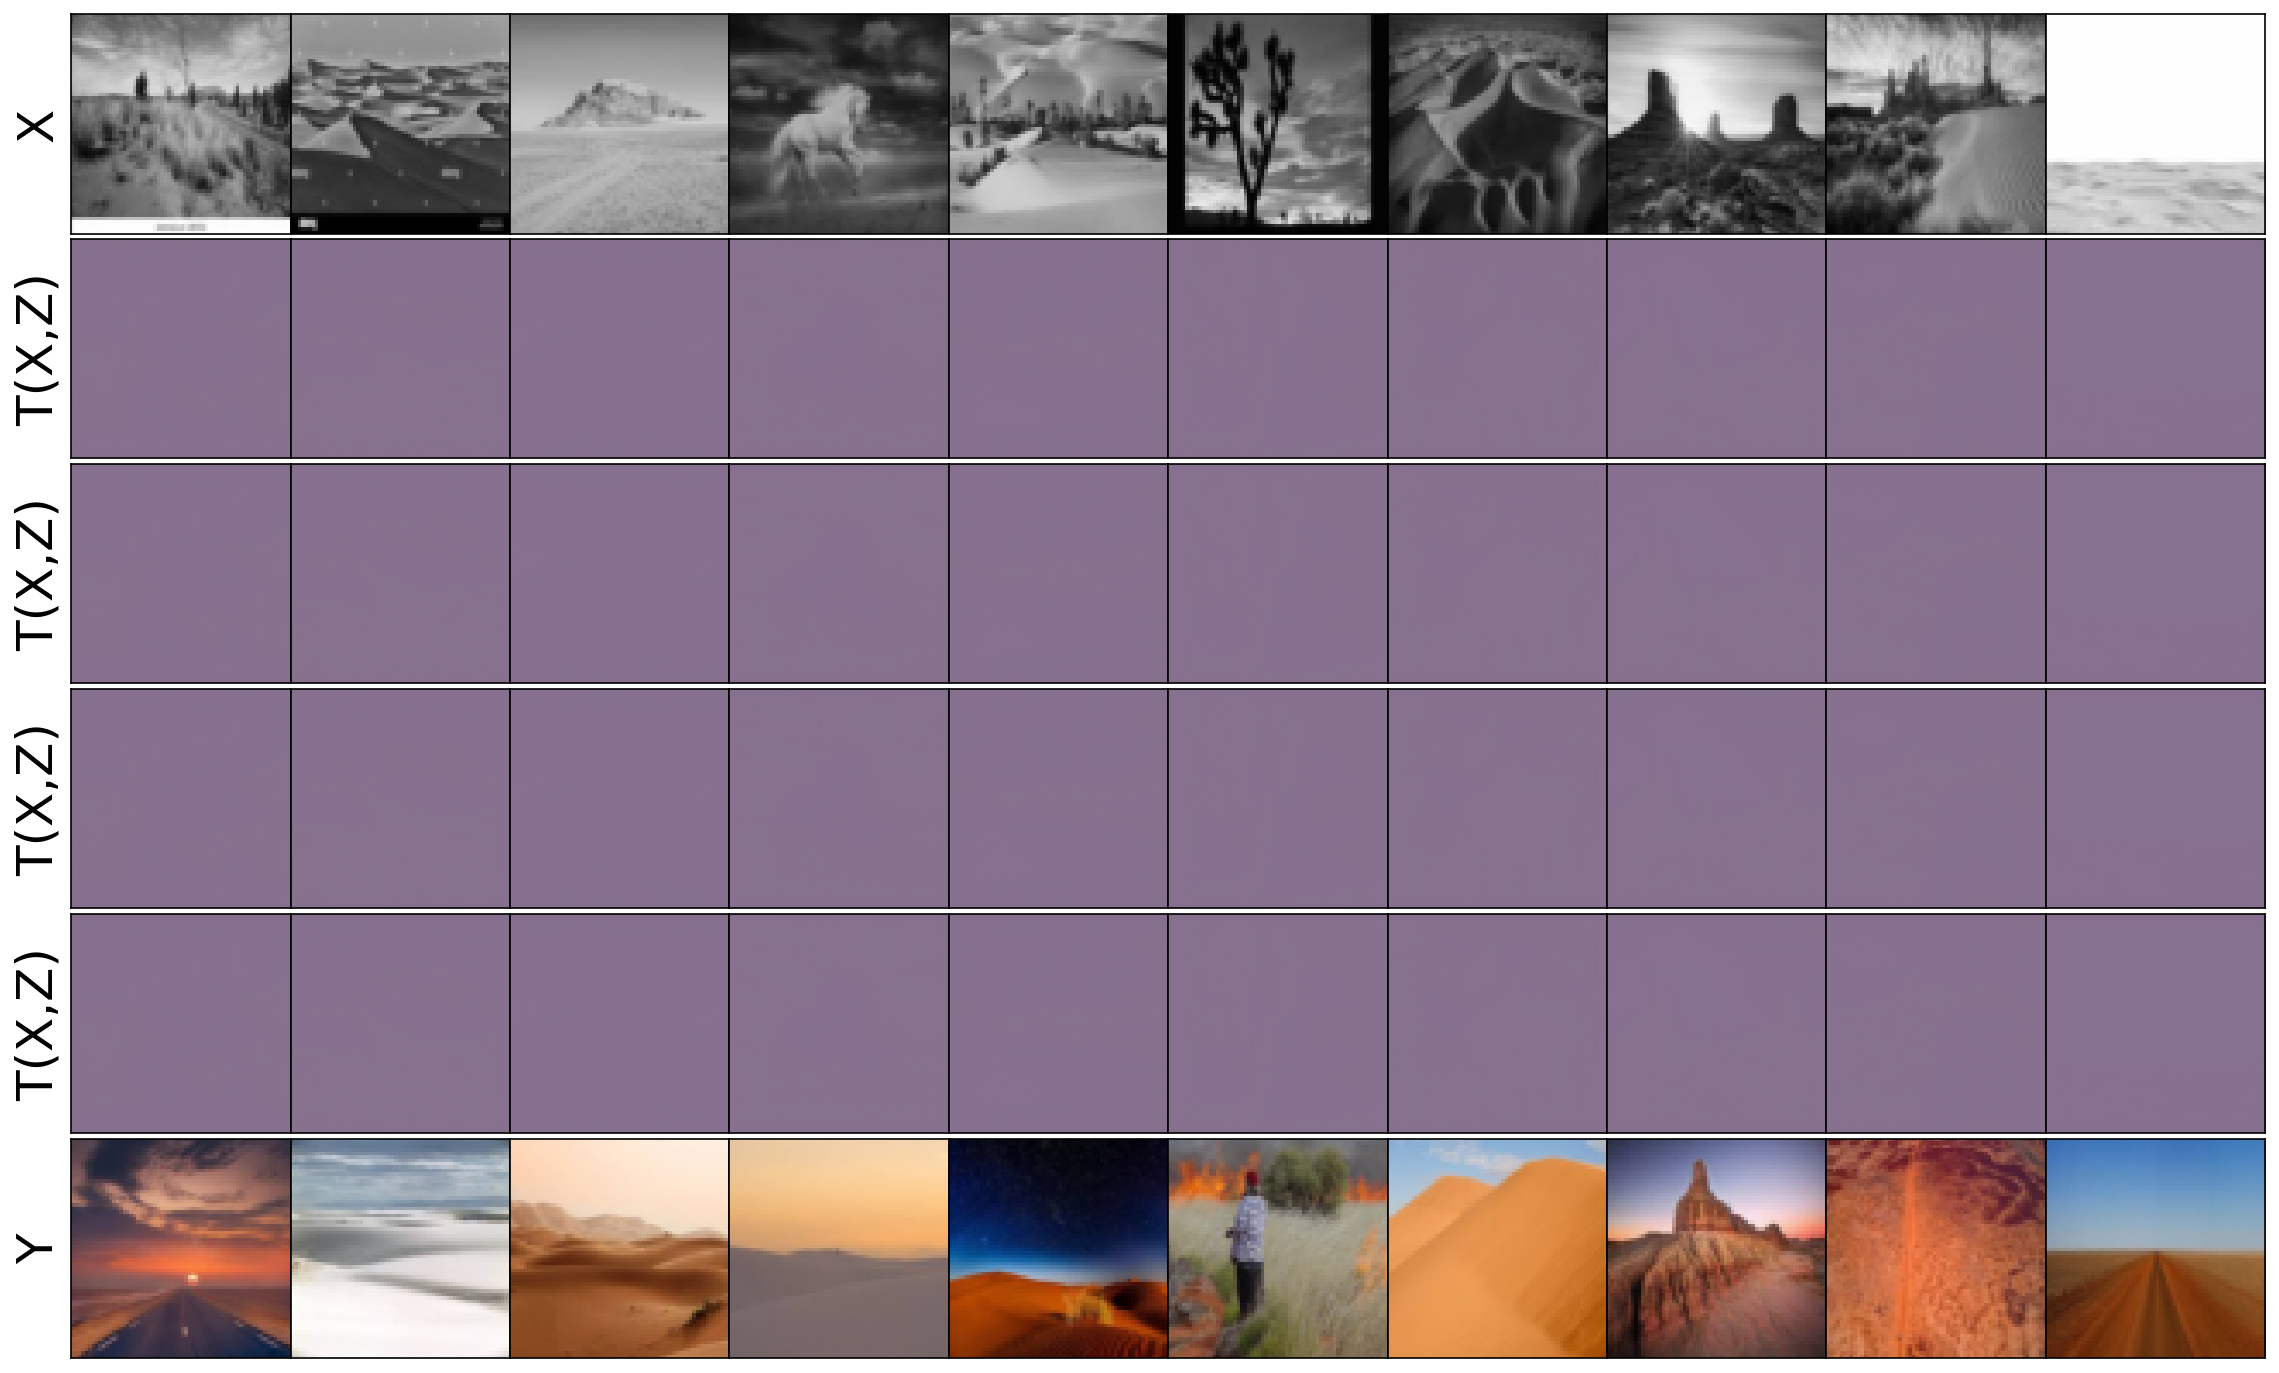

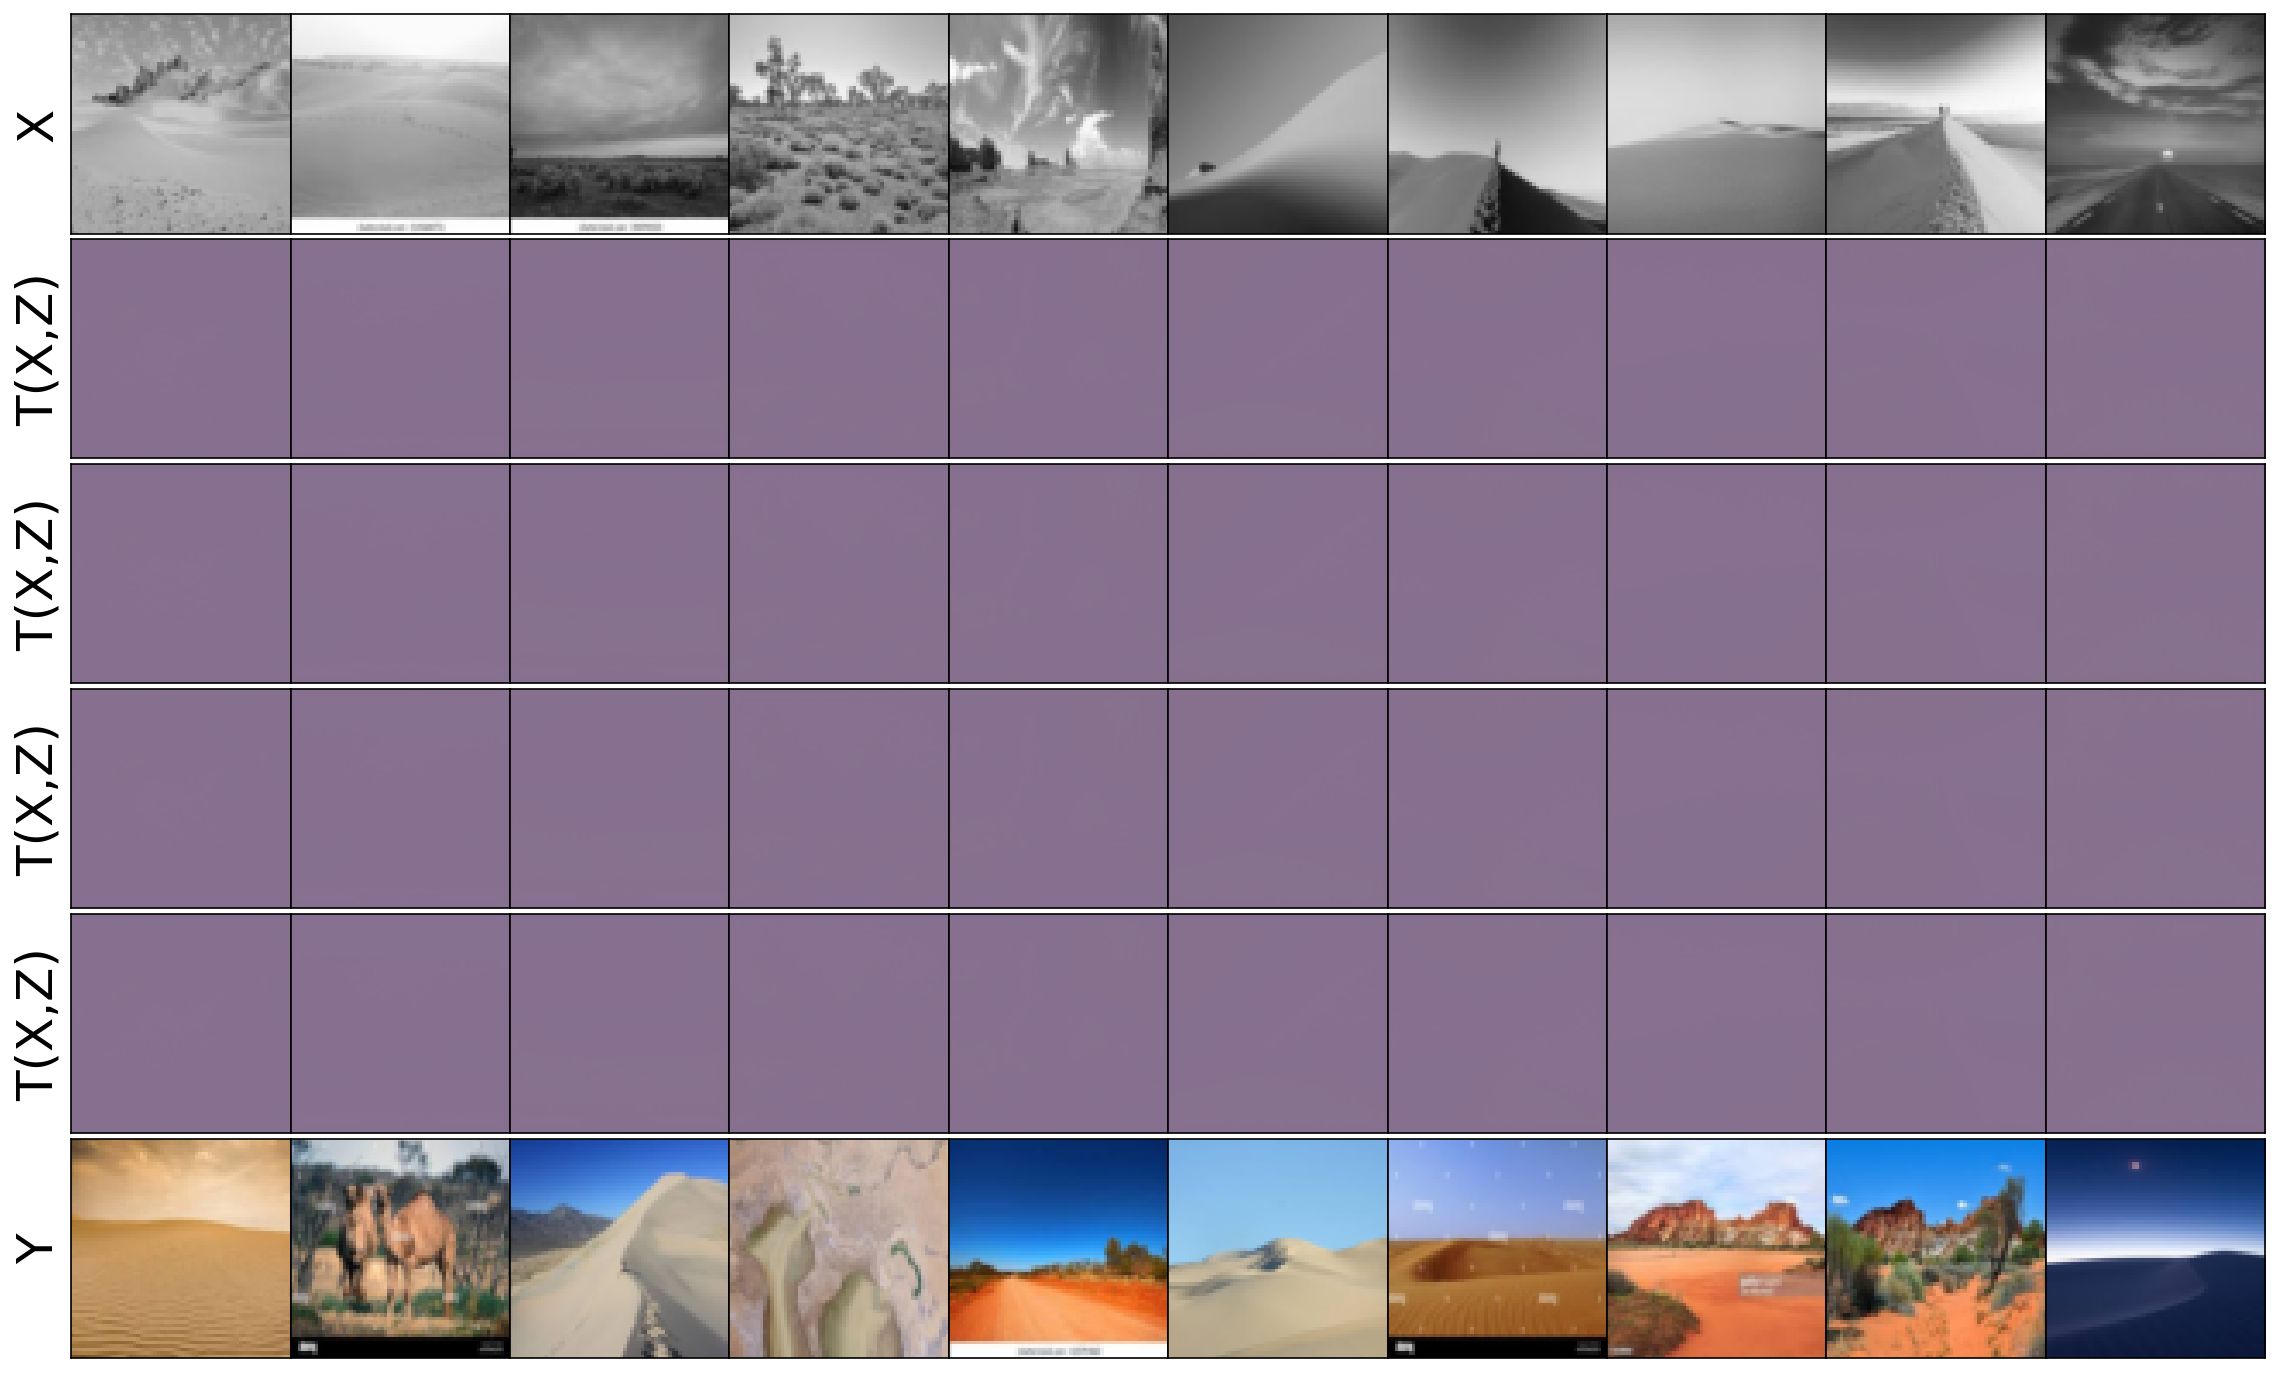

In [25]:
fig, axes = plot_Z_images(XZ_fixed, Y_fixed, T)
fig, axes = plot_random_Z_images(X_sampler, ZC, Z_STD, Y_sampler, T)
fig, axes = plot_Z_images(XZ_test_fixed, Y_test_fixed, T)
fig, axes = plot_random_Z_images(X_test_sampler, ZC, Z_STD, Y_test_sampler, T)

# Run Training

In [13]:
wandb.init(name=EXP_NAME, project='colorization_weak', entity='danymost04-cole-normale-sup-rieure-paris-saclay', config=config)
pass

In [14]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

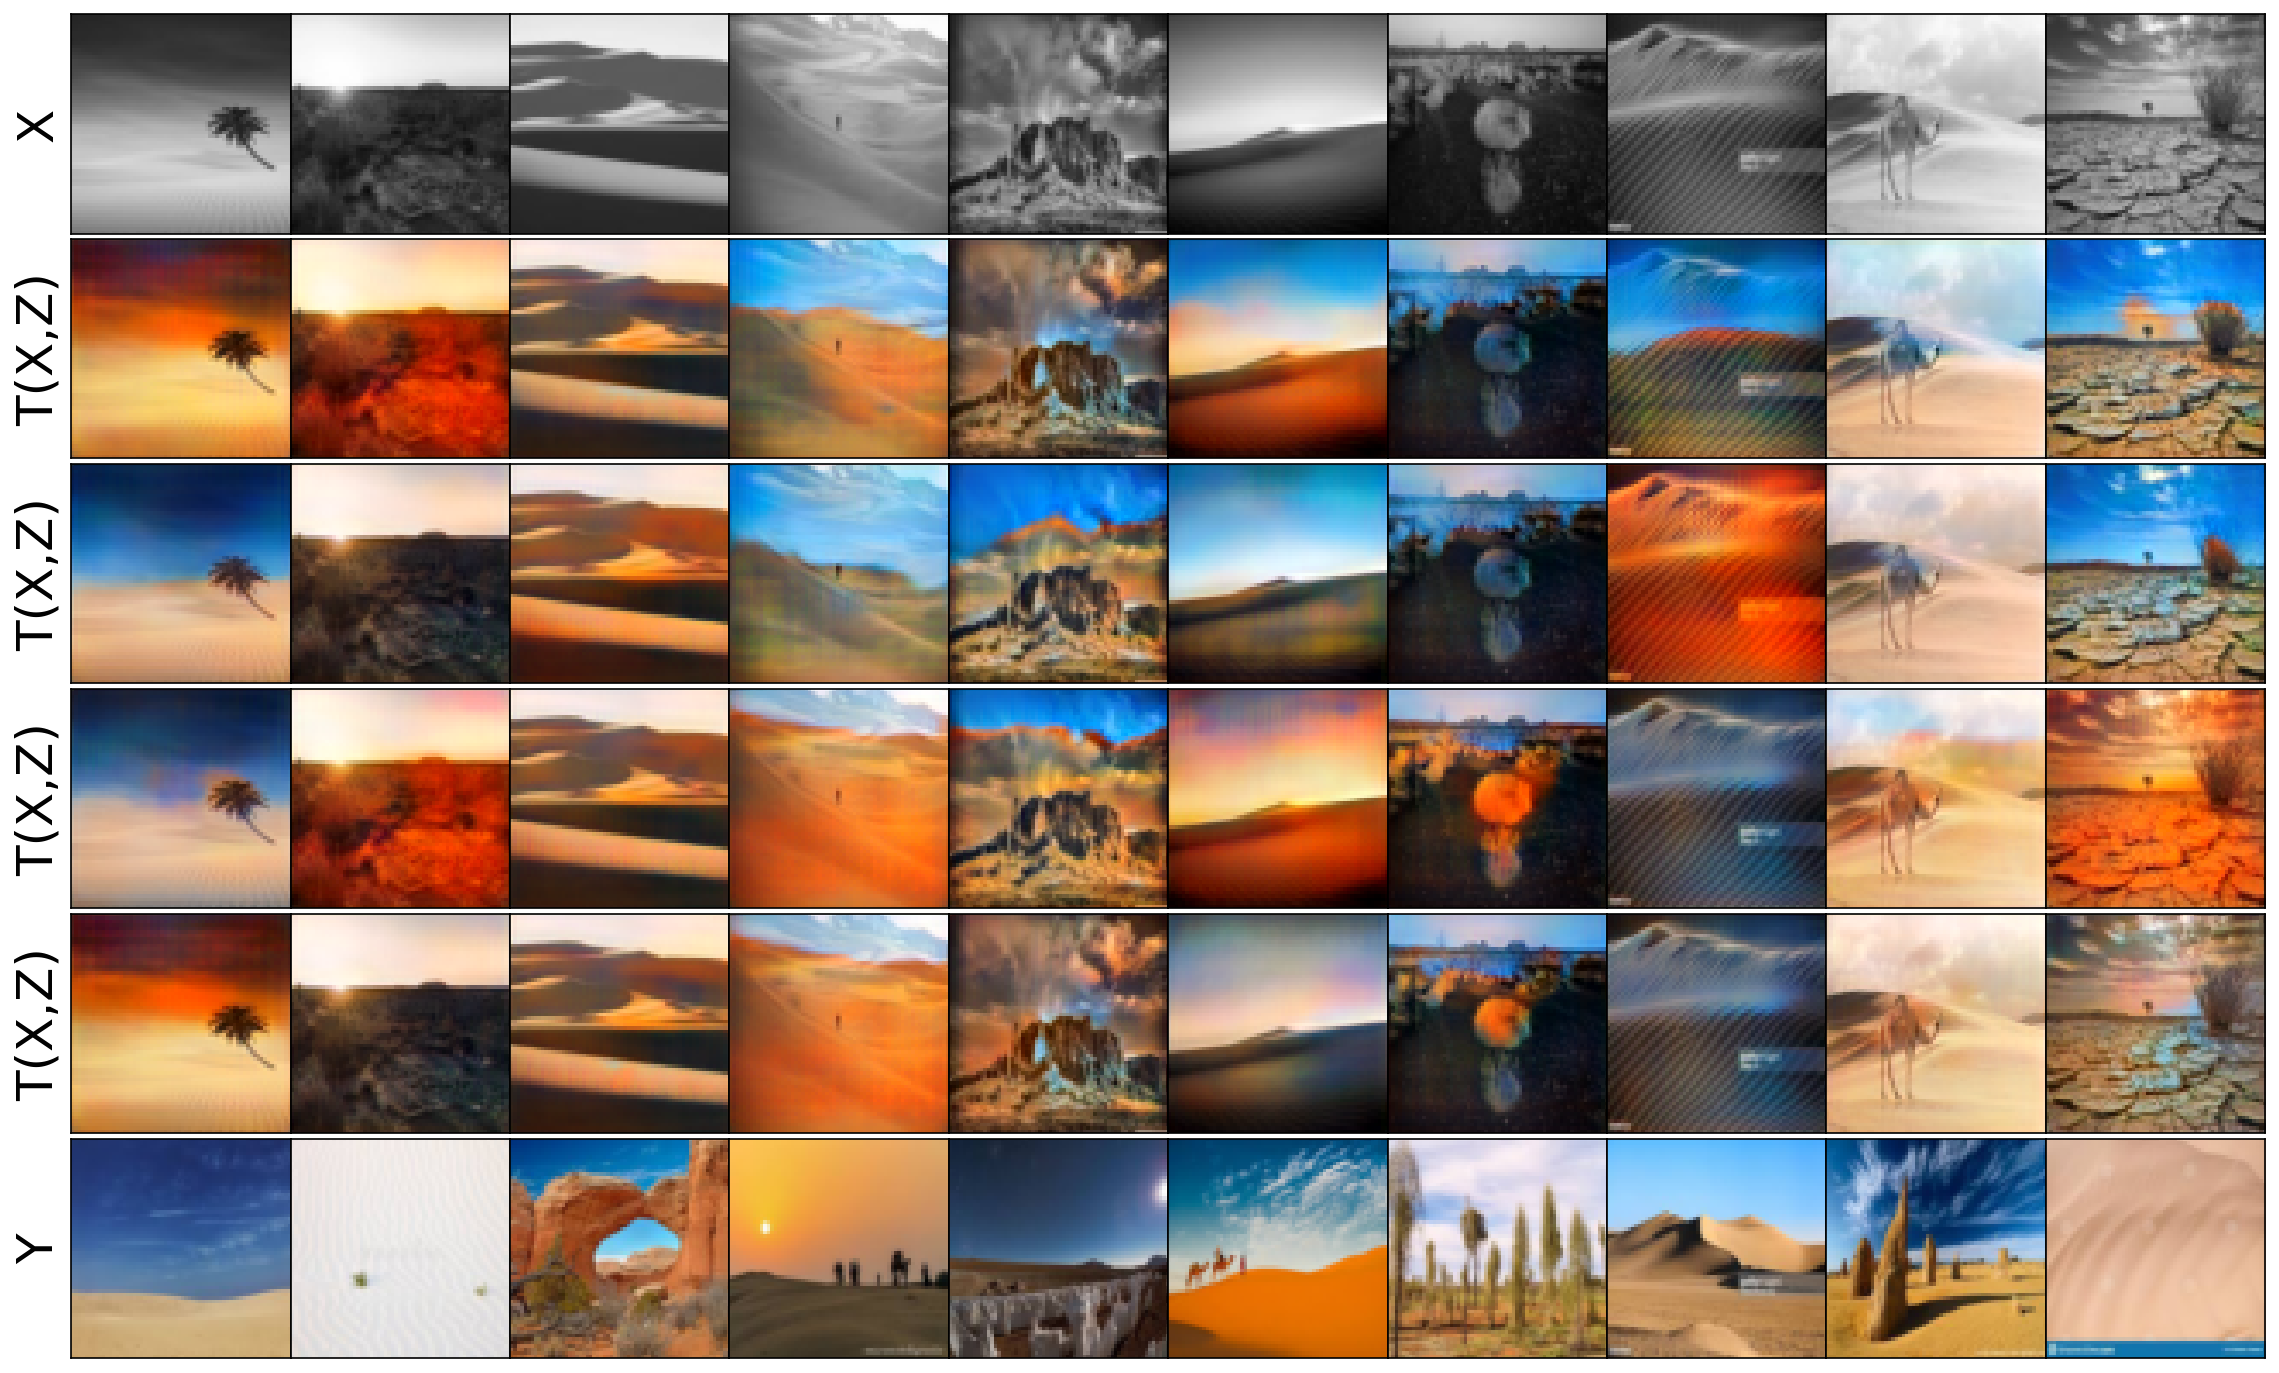

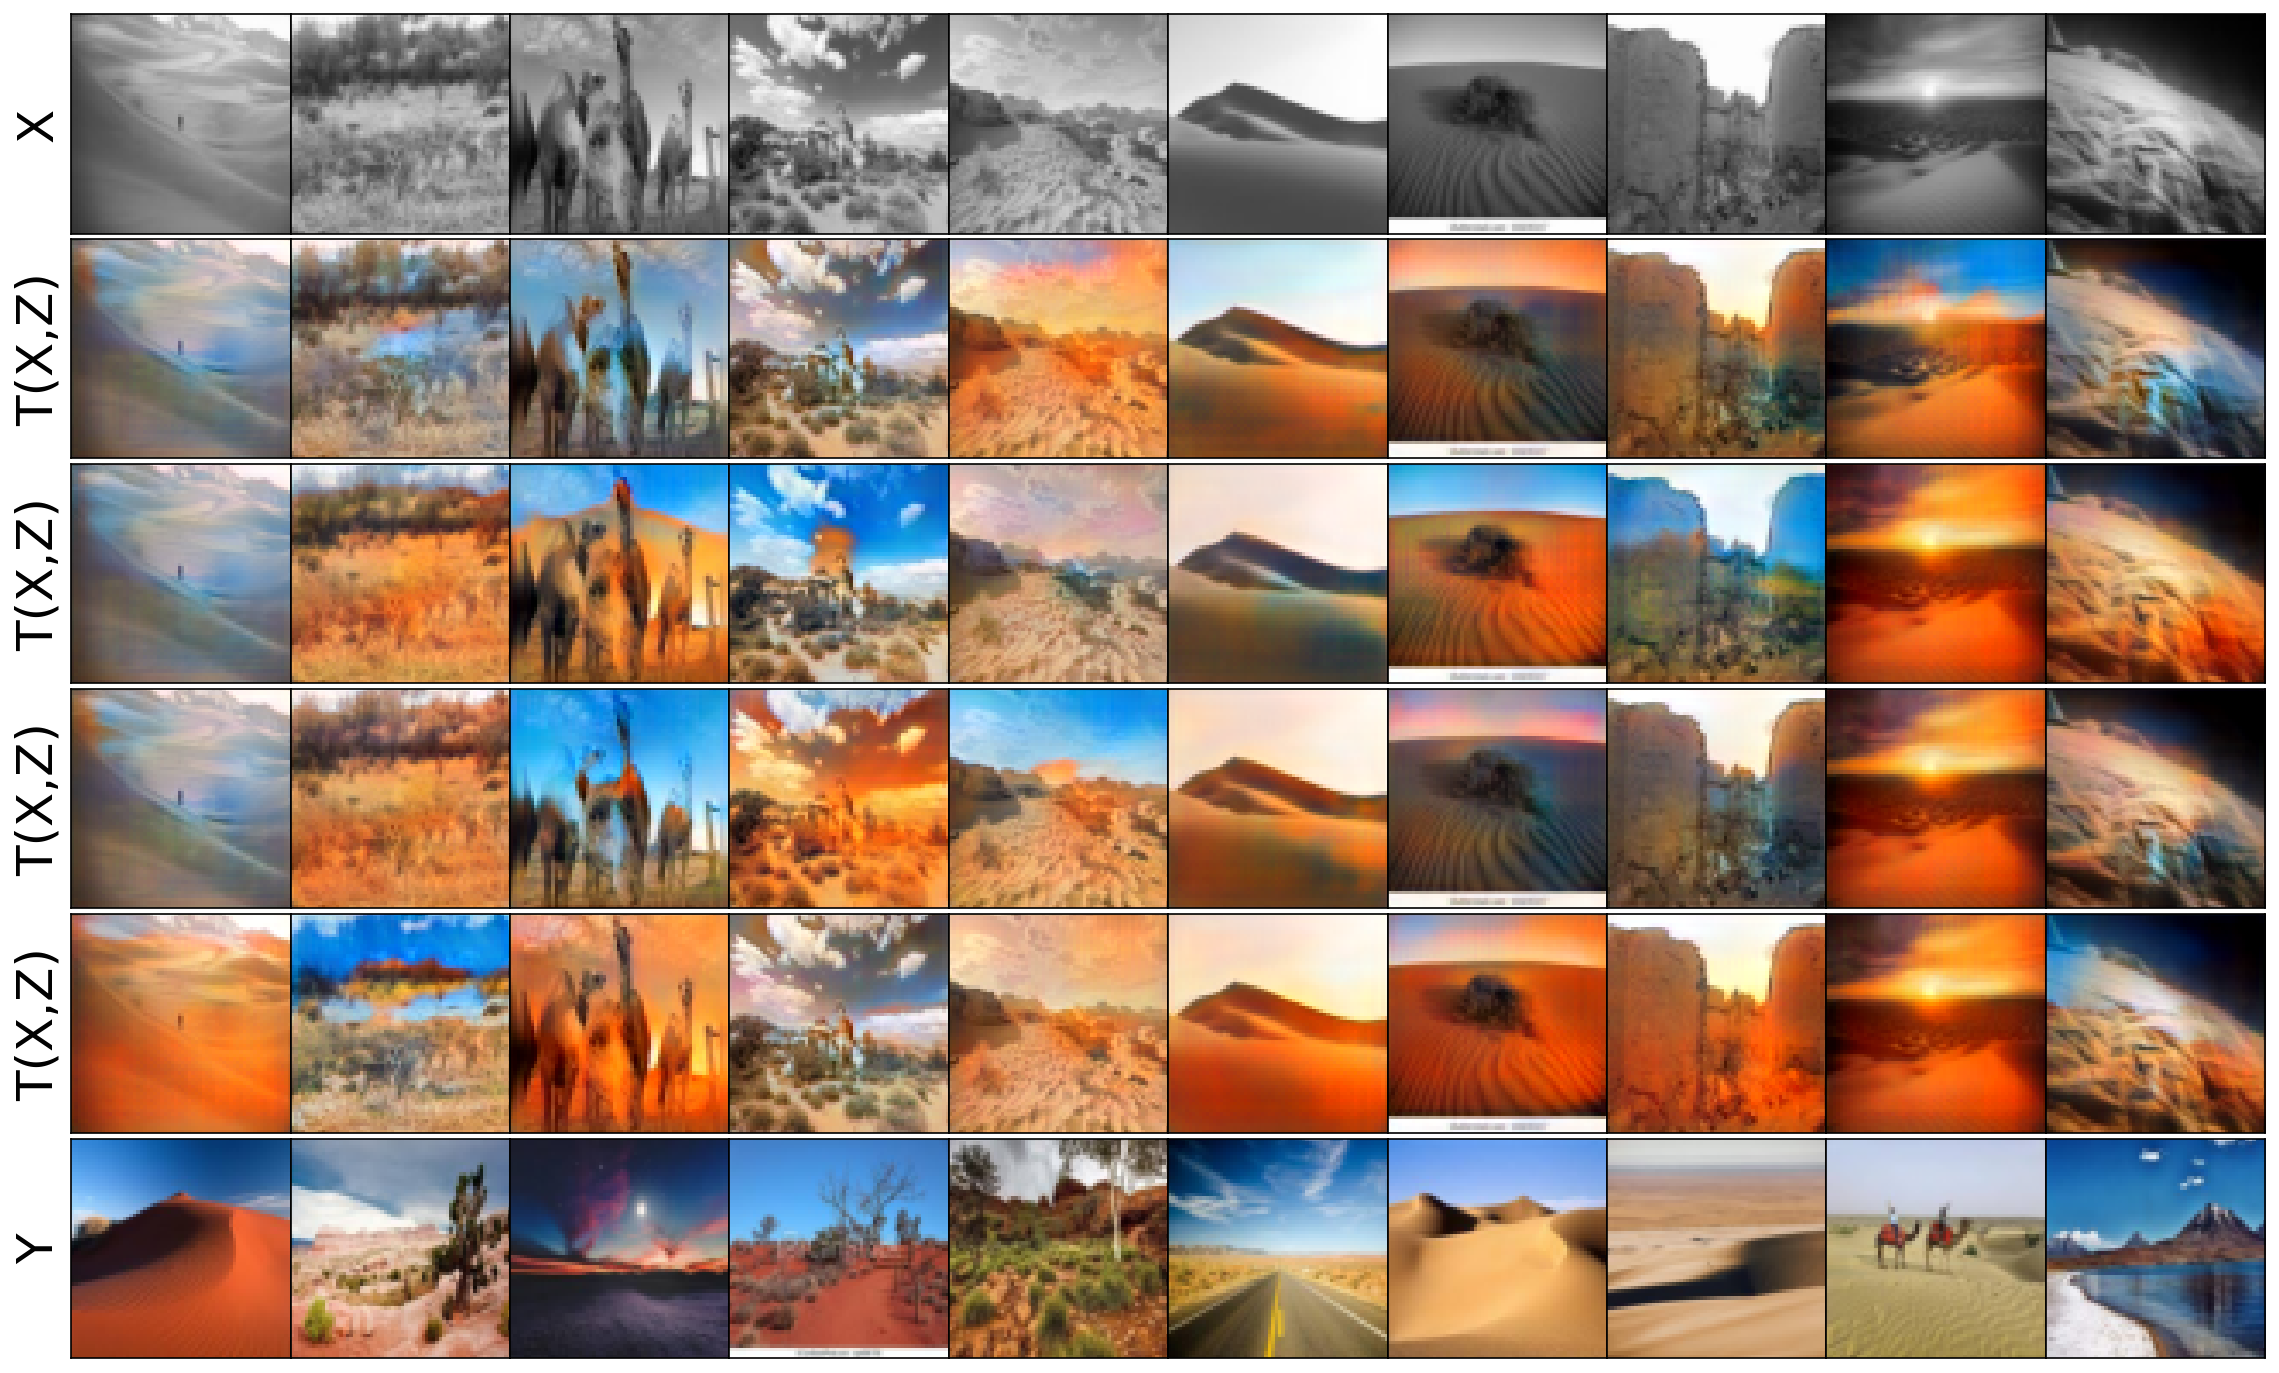

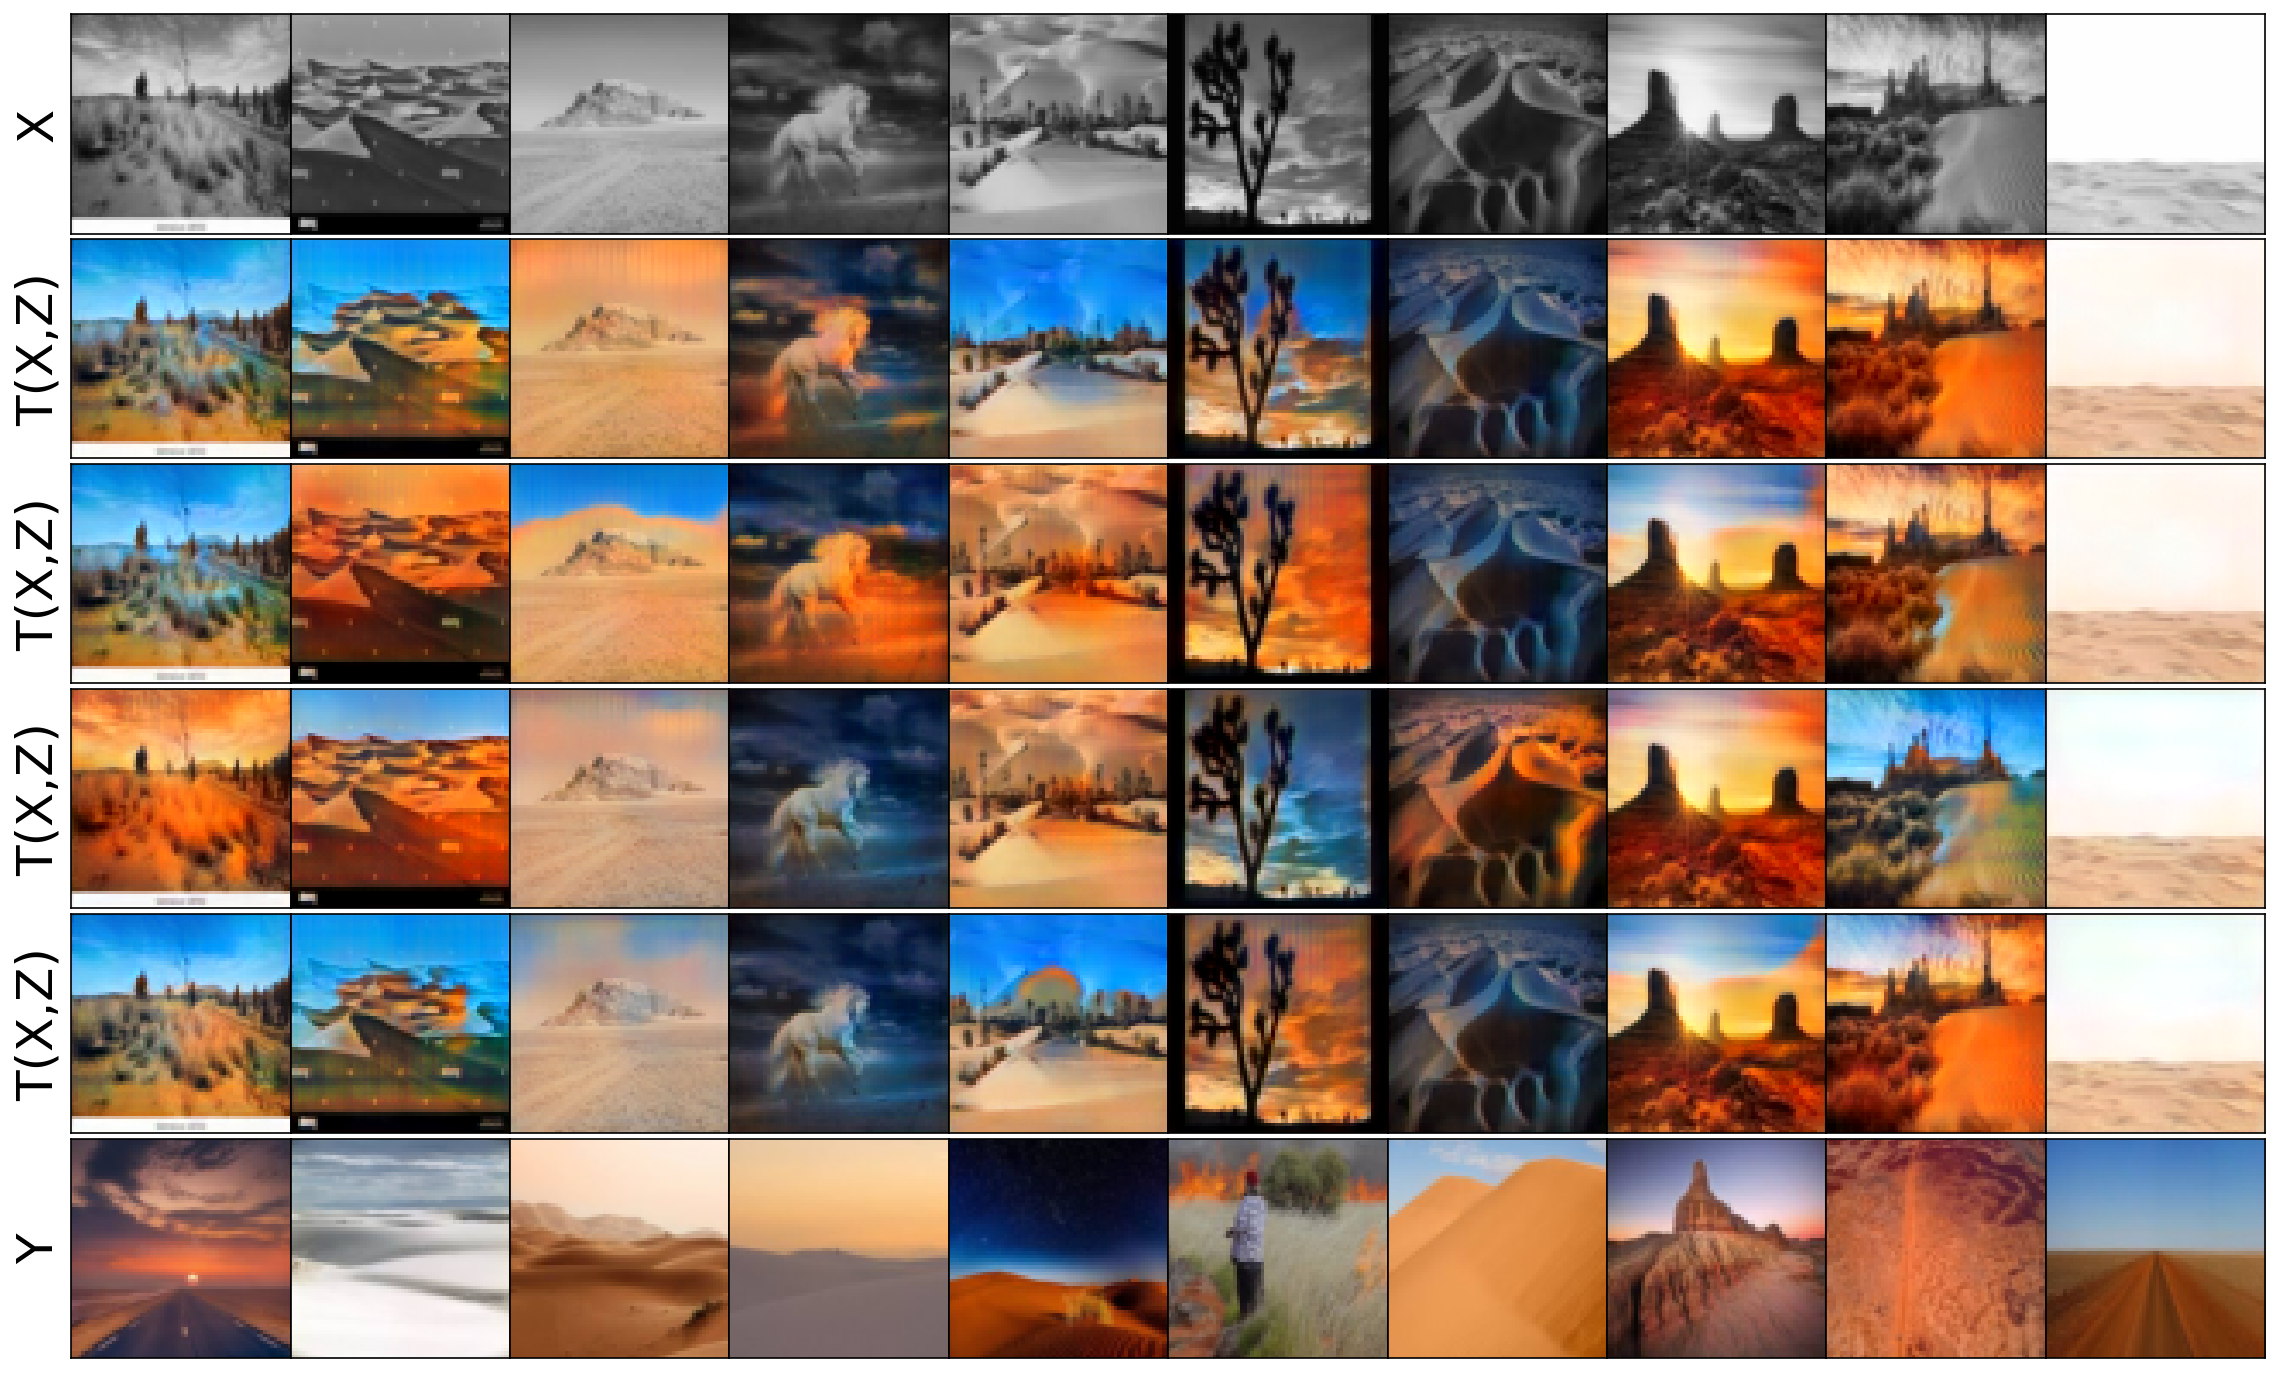

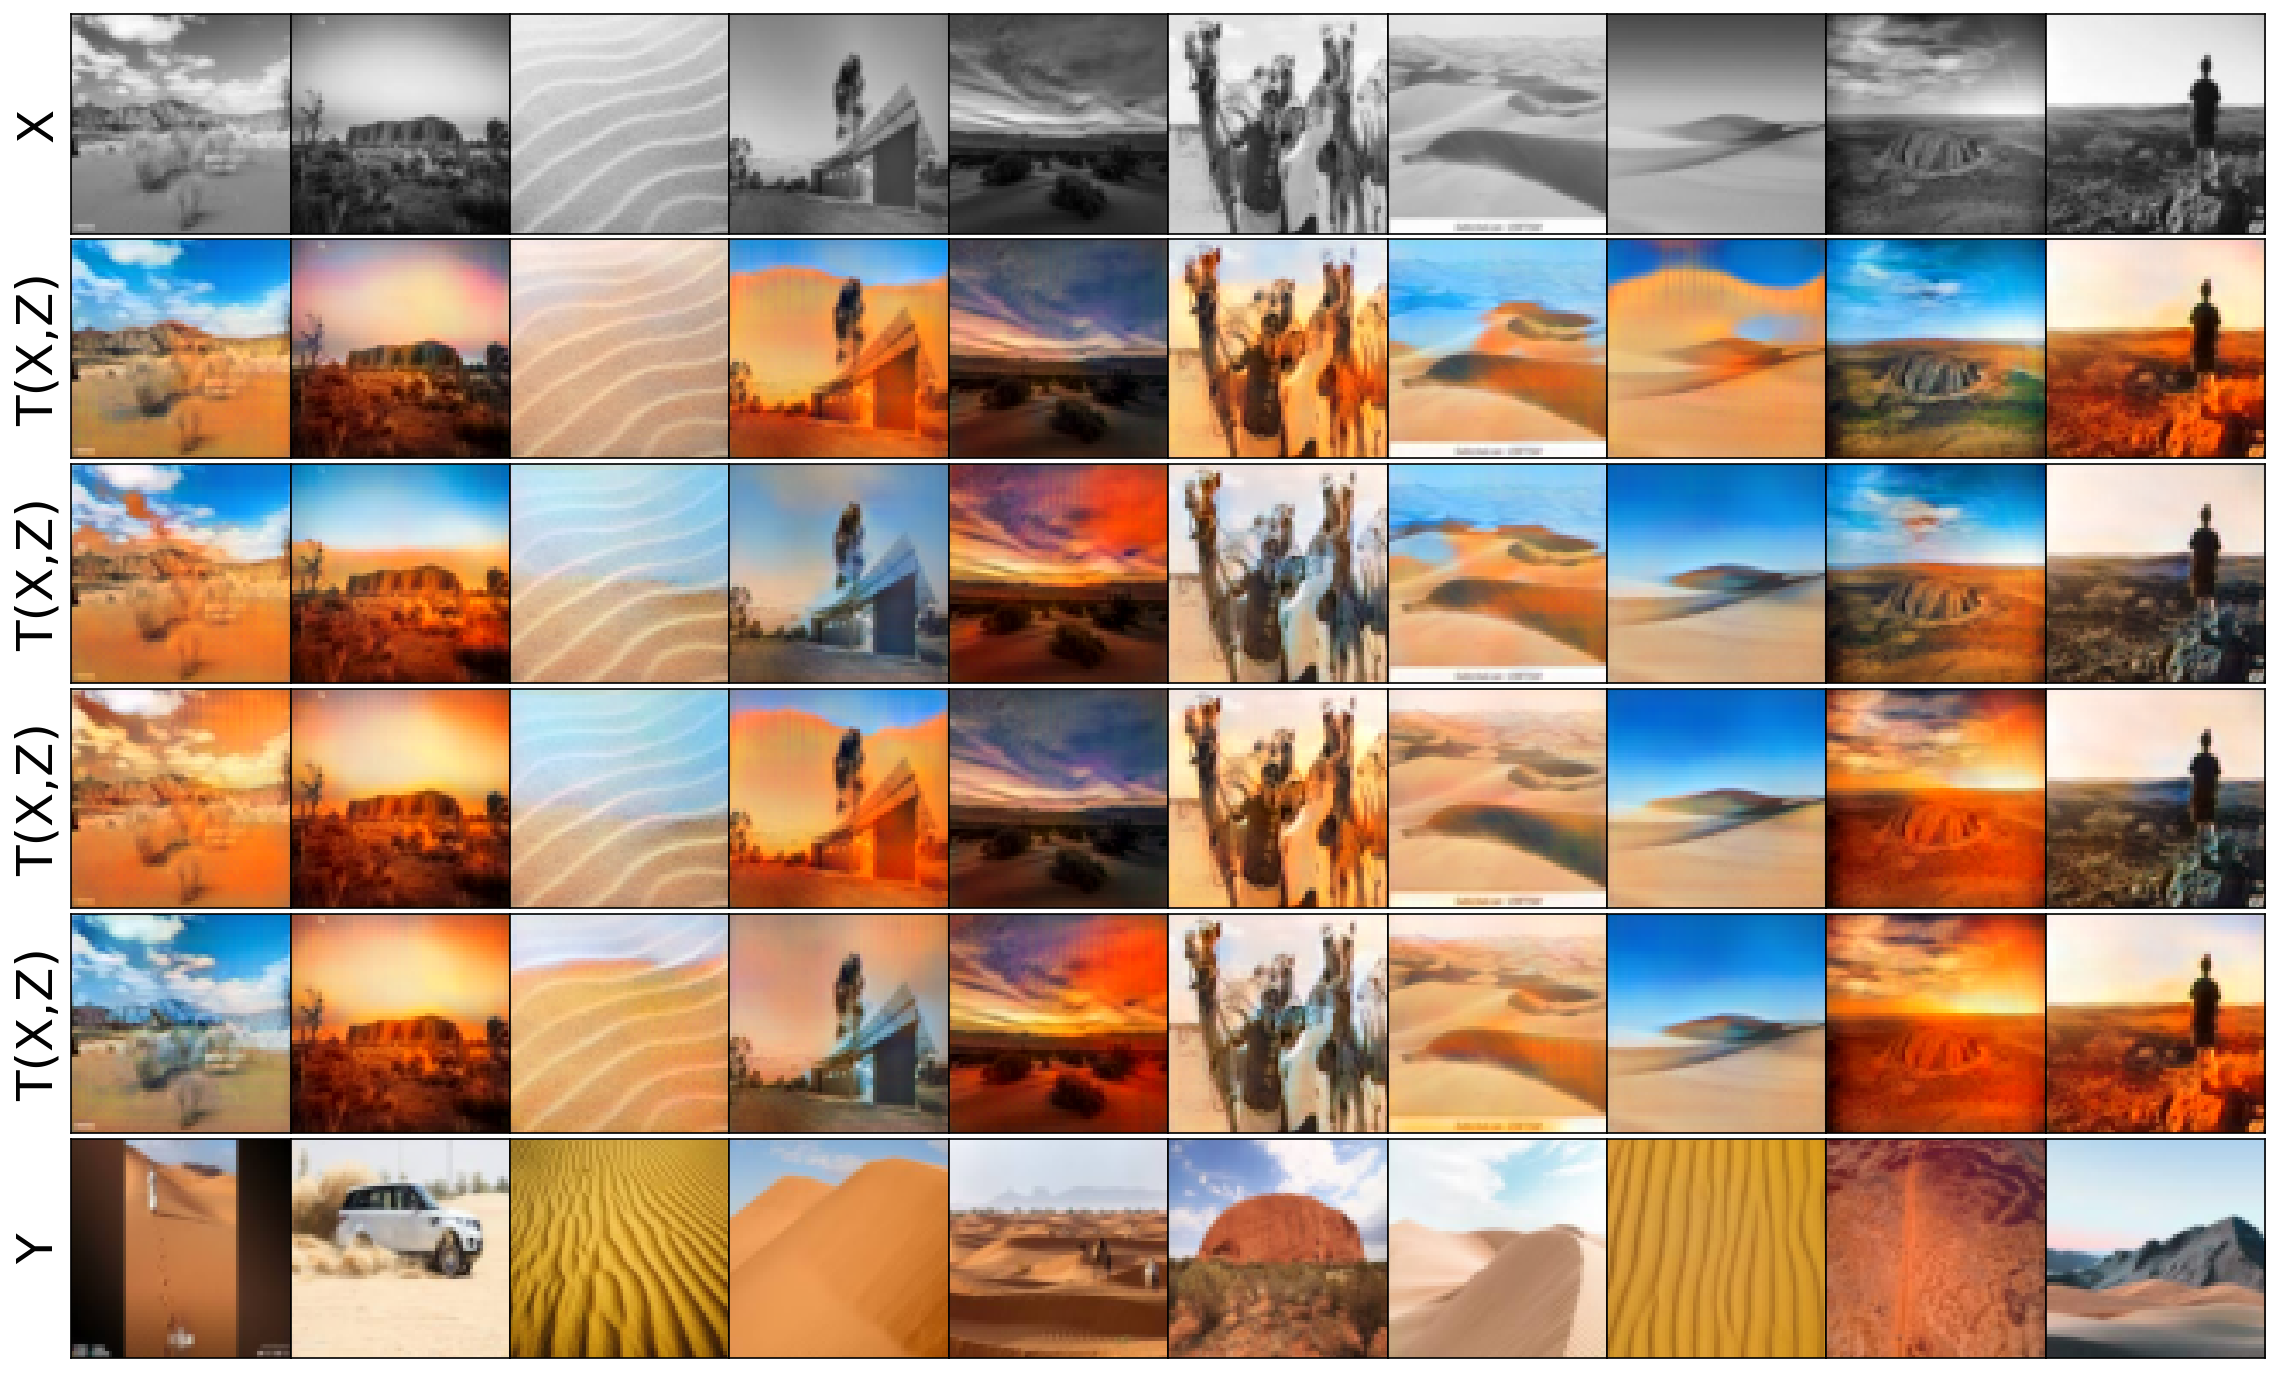

In [15]:
for step in tqdm(range(1901, MAX_STEPS)):
    gamma = min(GAMMA1, GAMMA0 + (GAMMA1-GAMMA0) * step / GAMMA_ITERS)
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)[:,None].repeat(1,Z_SIZE,1,1,1)
        with torch.no_grad():
            Z = torch.randn(BATCH_SIZE, Z_SIZE, ZC, IMG_SIZE, IMG_SIZE, device='cuda') * Z_STD
            XZ = torch.cat([X, Z], dim=2)
        T_XZ = T(
            XZ.flatten(start_dim=0, end_dim=1)
        ).permute(1,2,3,0).reshape(3, IMG_SIZE, IMG_SIZE, -1, Z_SIZE).permute(3,4,0,1,2)
        
        T_loss = F.mse_loss(X[:,0], T_XZ.mean(dim=1)).mean() - \
        f(T_XZ.flatten(start_dim=0, end_dim=1)).mean() + \
        T_XZ.var(dim=1).mean() * (1 - gamma - 1. / Z_SIZE)
        
        T_loss.backward(); T_opt.step()
    del T_loss, T_XZ, X, Z; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        Z = torch.randn(BATCH_SIZE, ZC, X.size(2), X.size(3), device='cuda') * Z_STD
        XZ = torch.cat([X,Z], dim=1)
        T_XZ = T(XZ)
    Y = Y_sampler.sample(BATCH_SIZE)
    f_opt.zero_grad()
    f_loss = f(T_XZ).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step();
    wandb.log({f'f_loss' : f_loss.item()}, step=step)
    del f_loss, Y, X, T_XZ, Z, XZ; gc.collect(); torch.cuda.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_Z_images(XZ_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_Z_images(X_sampler, ZC, Z_STD,  Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_Z_images(XZ_test_fixed, Y_test_fixed, T)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_Z_images(X_test_sampler, ZC, Z_STD,  Y_test_sampler, T)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig)
        torch.save(T.state_dict(), f"./models/T_{step}.pth")
        torch.save(f.state_dict(), f"./models/f_{step}.pth")
    gc.collect(); torch.cuda.empty_cache()

## Testing the network

In [26]:
f = ResNet_D(IMG_SIZE, nc=3).cuda()
#f.load_state_dict(torch.load("./models/f_1900.pth", weights_only = True))
T = UNet(3+ZC, 3, base_factor=48).cuda() # ZC - noise input channels z
T.load_state_dict(torch.load("./models/T_4800.pth", weights_only = True))
f.load_state_dict(torch.load("./models/f_4800.pth", weights_only = True))

<All keys matched successfully>

In [46]:
X = X_sampler.sample(BATCH_SIZE)[:,None].repeat(1,Z_SIZE,1,1,1)
with torch.no_grad():
    Z = torch.randn(BATCH_SIZE, Z_SIZE, ZC, IMG_SIZE, IMG_SIZE, device='cuda') * Z_STD
    XZ = torch.cat([X, Z], dim=2)
X.shape

torch.Size([64, 8, 3, 64, 64])

In [75]:
  
# reading png image file 
filename = "desert_test.jpg"
image = img.imread(filename)
transforms_gray =  transforms.Compose([
            transforms.ToTensor(),  
            transforms.Resize((64, 64)),  # Ensure correct size
                  # Convert to tensor
           
            torchvision.transforms.Grayscale(num_output_channels=3),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
transforms_color =  transforms.Compose([
            transforms.ToTensor(),  
            transforms.Resize((64, 64)),  # Ensure correct size
                  # Convert to tensor
           
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
gray_image = transforms_gray(image).to(DEVICE)
ground_truth = transforms_color(image).to(DEVICE)

In [50]:
X = gray_image[None, None, :].repeat(1,Z_SIZE,1,1,1)
with torch.no_grad():
    Z = torch.randn(1, Z_SIZE, ZC, IMG_SIZE, IMG_SIZE, device='cuda') * Z_STD
    XZ = torch.cat([X, Z], dim=2)
    T_XZ = T(
        XZ.flatten(start_dim=0, end_dim=1)
    ).permute(1,2,3,0).reshape(3, IMG_SIZE, IMG_SIZE, -1, Z_SIZE).permute(3,4,0,1,2)

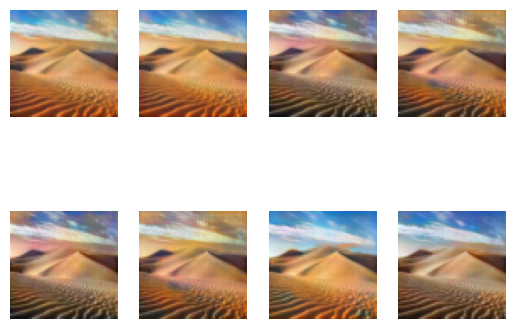

In [70]:
fig, ax = plt.subplots(2,4)
for i in range(0, 2):
    for j in range(0, 4):
        generated_image = T_XZ[0, i * 2 + j].permute(1, 2, 0).cpu().numpy()
        generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())
        ax[i, j].imshow(generated_image)
        ax[i, j].set_axis_off()

plt.show()

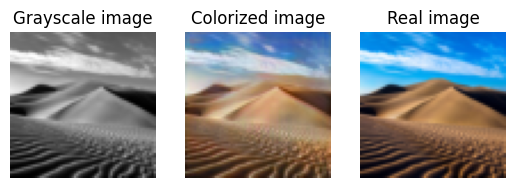

In [97]:
fig, ax = plt.subplots(1, 3)
image_gray = gray_image.cpu().permute(1, 2, 0).numpy()
image_gray = (image_gray - image_gray.min()) / (image_gray.max() - image_gray.min())
ax[0].set_title("Grayscale image")
ax[0].imshow(image_gray)
ax[0].set_axis_off()
generated_image = T_XZ[0, i * 2 + j].permute(1, 2, 0).cpu().numpy()
generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())
ax[1].set_title("Colorized image")
ax[1].imshow(generated_image)
ax[1].set_axis_off()
image_ground = ground_truth.cpu().permute(1, 2, 0).numpy()
image_ground = (image_ground - image_ground.min()) / (image_ground.max() - image_ground.min())
ax[2].set_title("Real image")
ax[2].imshow(image_ground)
ax[2].set_axis_off()
fig.savefig("Test desert", bbox_inches='tight')

## Style transfer

In [3]:
DEVICE_IDS = [0]

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 32
ZC = 1
Z_STD = 0.1
Z_SIZE = 8
BATCH_SIZE = 64

PLOT_INTERVAL = 100
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 2000
MAX_STEPS = 5000
SEED = 0x000000
GAMMA0, GAMMA1 = 0.0, 0.66
GAMMA_ITERS = 2500

DATASET1 = "SourceCat"
DATASET2 = "TargetCat"
EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}'
OUTPUT_PATH = '../checkpoints/{}/{}_{}_{}/'.format(COST, DATASET1, DATASET2, IMG_SIZE)
DEVICE = "cuda"

In [4]:
config = dict(
    DATASET1 = DATASET1,
    DATASET2 = DATASET2,
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [5]:
class CatTargetDataset(Dataset):
    def __init__(self, grayscale = True):
        
        super().__init__()
        X = []
        loaded = np.load("../datasets/transfert_style/cat_target.npy")
        if grayscale:
            self.transforms =  transforms.Compose([
            transforms.ToTensor(),  
            transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Ensure correct size
                  # Convert to tensor
           
            torchvision.transforms.Grayscale(num_output_channels=3),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        else:
            
            self.transforms = transforms.Compose([
            transforms.ToTensor(),  
            transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Ensure correct size
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        ])
        h, w = int(np.sqrt(len(loaded[0]))), int(np.sqrt(len(loaded[0])))
        for img in (loaded):
            
            img = img.reshape(h, w)
            img = np.stack([img] * 3, axis=-1)
            X.append(self.transforms(img))
        self.X = X

        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], 0

In [6]:
class CatSourceDataset(Dataset):
    def __init__(self, grayscale = True):
        
        super().__init__()
        X = []
        dataset_dir = "../datasets/transfert_style/cat_source/Data"
        if grayscale:
            self.transforms =  transforms.Compose([
            transforms.ToTensor(),  
            transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Ensure correct size
                  # Convert to tensor
           
            torchvision.transforms.Grayscale(num_output_channels=3),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        else:
            
            self.transforms = transforms.Compose([
            transforms.ToTensor(),  
            transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Ensure correct size
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        ])
        for filename in os.listdir(dataset_dir):

            file_path_X = dataset_dir + "/" + filename
            if file_path_X.split(".")[-1] == "png":
                imgX = mpimg.imread(file_path_X)
                X.append(self.transforms(np.array(imgX)))
        self.X = X

        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], 0

In [7]:
dataset_source = CatSourceDataset()


In [8]:
dataset_target = CatTargetDataset()

In [9]:
import numpy as np
np.random.seed(42)
indices_source = torch.randperm(len(dataset_source)).tolist()
indices_target = torch.randperm(len(dataset_target)).tolist()
train_size_source = int(0.7 * len(dataset_source))
train_size_target = int(0.7 * len(dataset_target))
train_indices_source, val_indices_source = indices_source[:train_size_source], indices_source[train_size_source:]
train_indices_target, val_indices_target = indices_target[:train_size_target], indices_target[train_size_target:]

# Create subsets using the same indices
train_dataset_X, val_dataset_X, = Subset(dataset_source, train_indices_source), Subset(dataset_source, val_indices_source)
train_dataset_Y, val_dataset_Y = Subset(dataset_target, train_indices_target), Subset(dataset_target, val_indices_target)


In [10]:
X_sampler = LoaderSampler(DataLoader(train_dataset_X, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), DEVICE )
Y_sampler = LoaderSampler(DataLoader(train_dataset_Y, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), DEVICE)
X_test_sampler = LoaderSampler(DataLoader(val_dataset_X, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), DEVICE)
Y_test_sampler = LoaderSampler(DataLoader(val_dataset_Y, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), DEVICE)

In [11]:

f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)
T = UNet(3+ZC, 3, base_factor=48).cuda() # ZC - noise input channels z
if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 9716259
f params: 13494209


In [12]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)[:,None].repeat(1,4,1,1,1)
with torch.no_grad():
    Z_fixed = torch.randn(10, 4, ZC, IMG_SIZE, IMG_SIZE, device='cuda') * Z_STD
    XZ_fixed = torch.cat([X_fixed, Z_fixed], dim=2)
del X_fixed, Z_fixed
Y_fixed = Y_sampler.sample(10)

X_test_fixed = X_test_sampler.sample(10)[:,None].repeat(1,4,1,1,1)
with torch.no_grad():
    Z_test_fixed = torch.randn(10, 4, ZC, IMG_SIZE, IMG_SIZE, device='cuda') * Z_STD
    XZ_test_fixed = torch.cat([X_test_fixed, Z_test_fixed], dim=2)
del X_test_fixed, Z_test_fixed
Y_test_fixed = Y_test_sampler.sample(10)

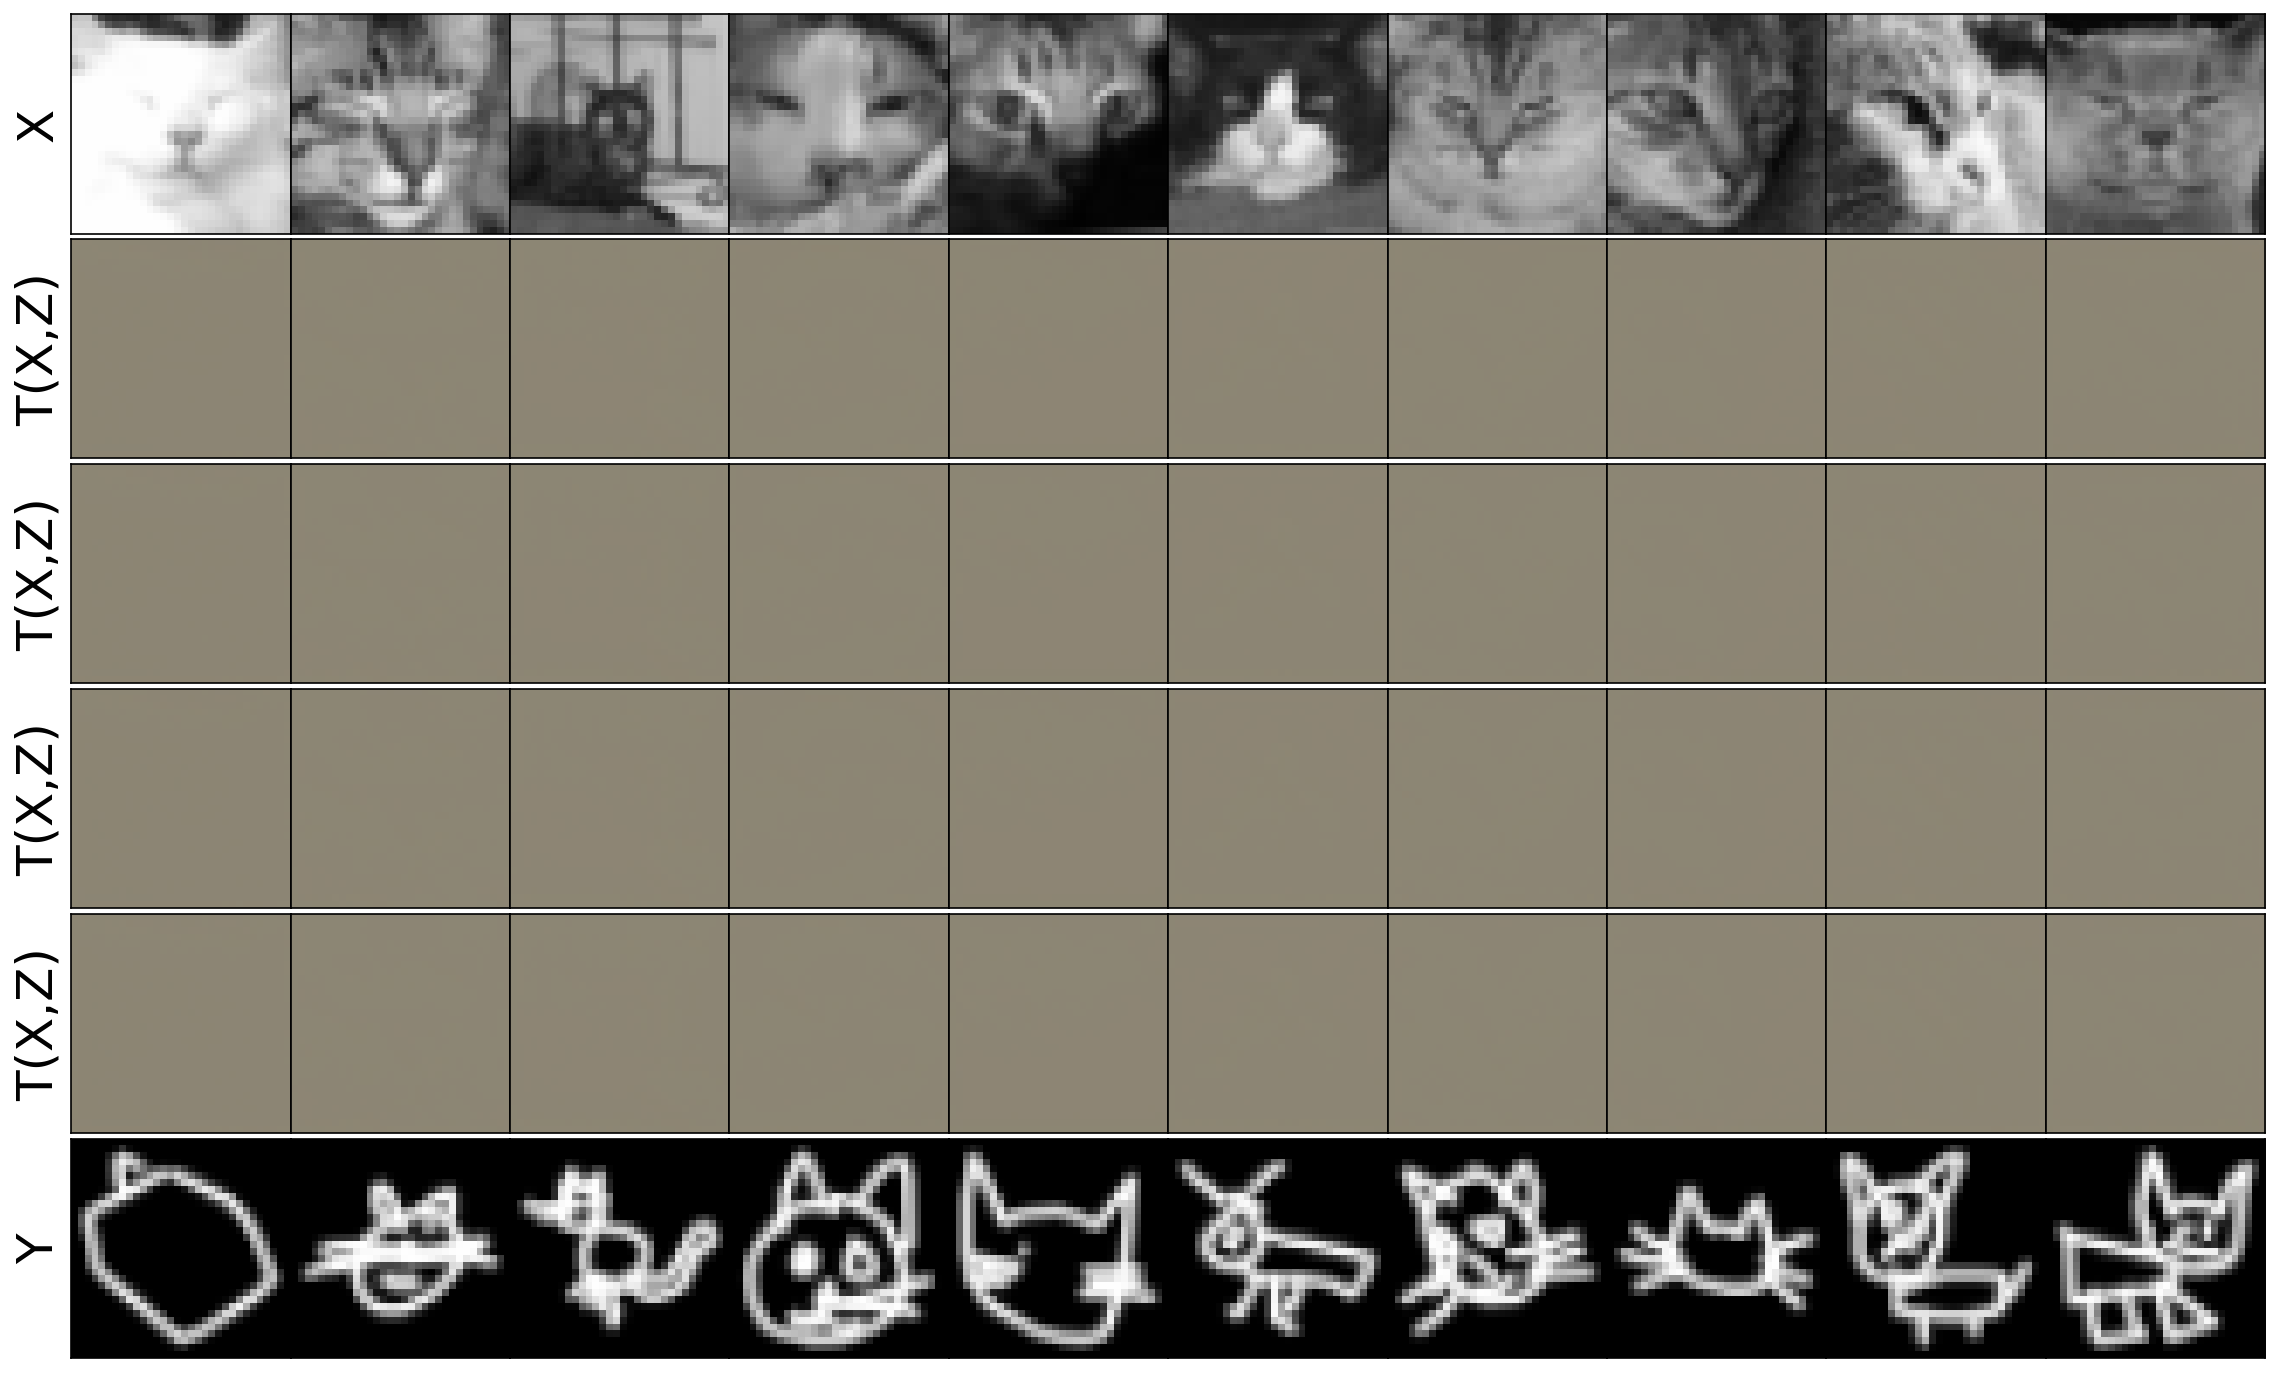

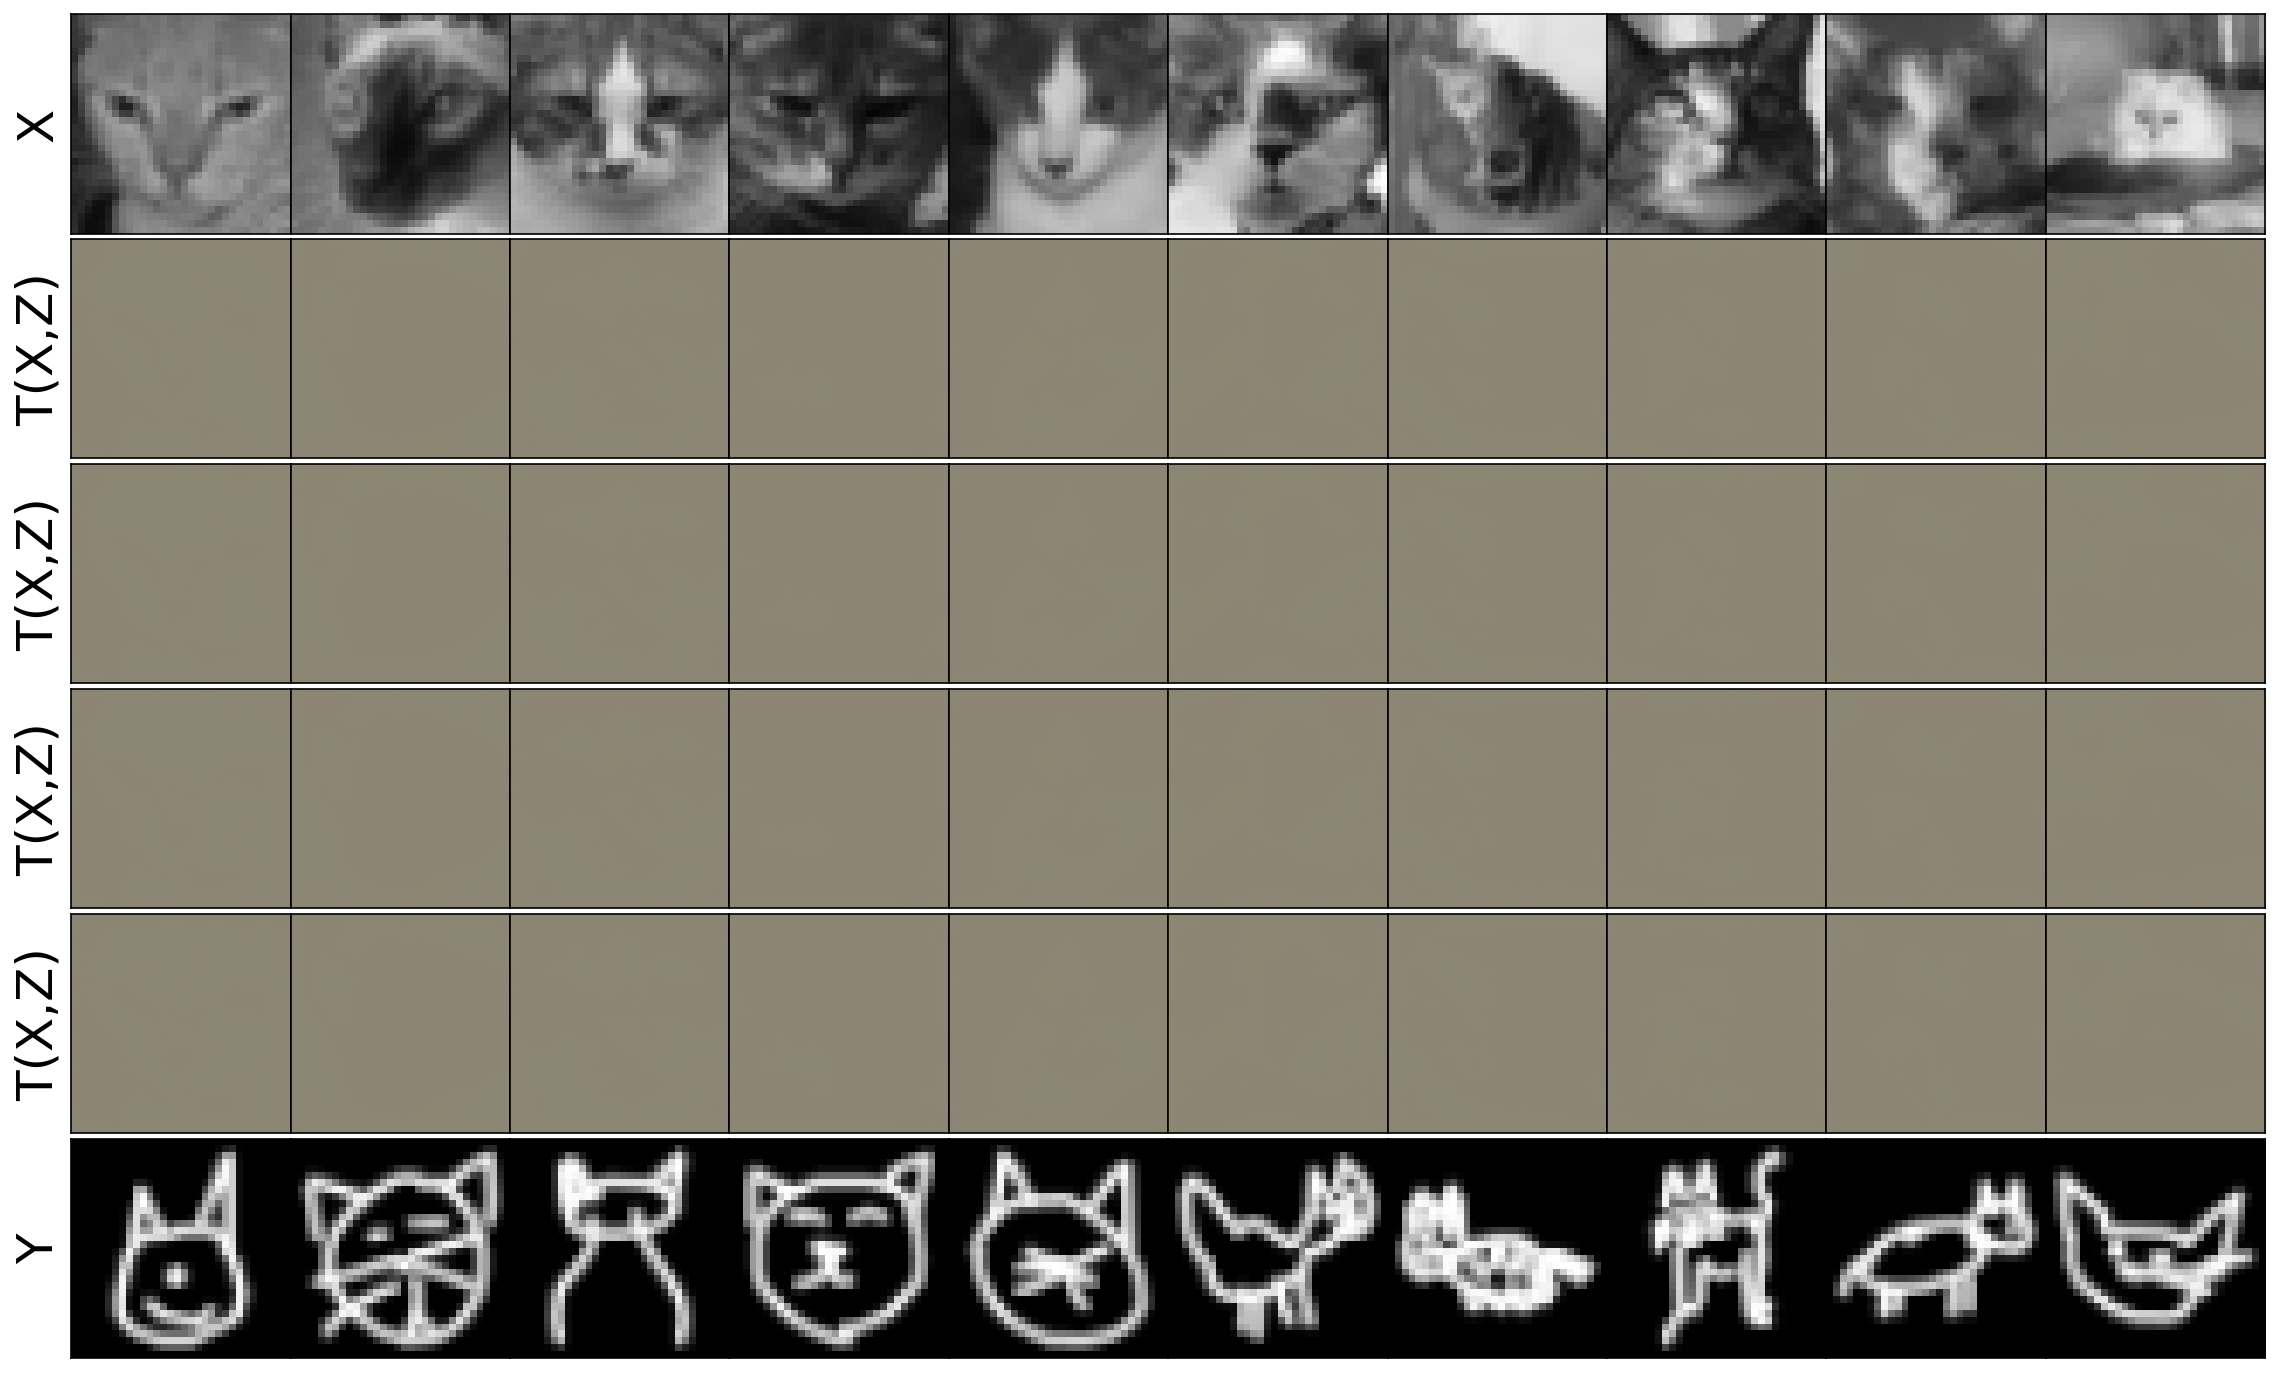

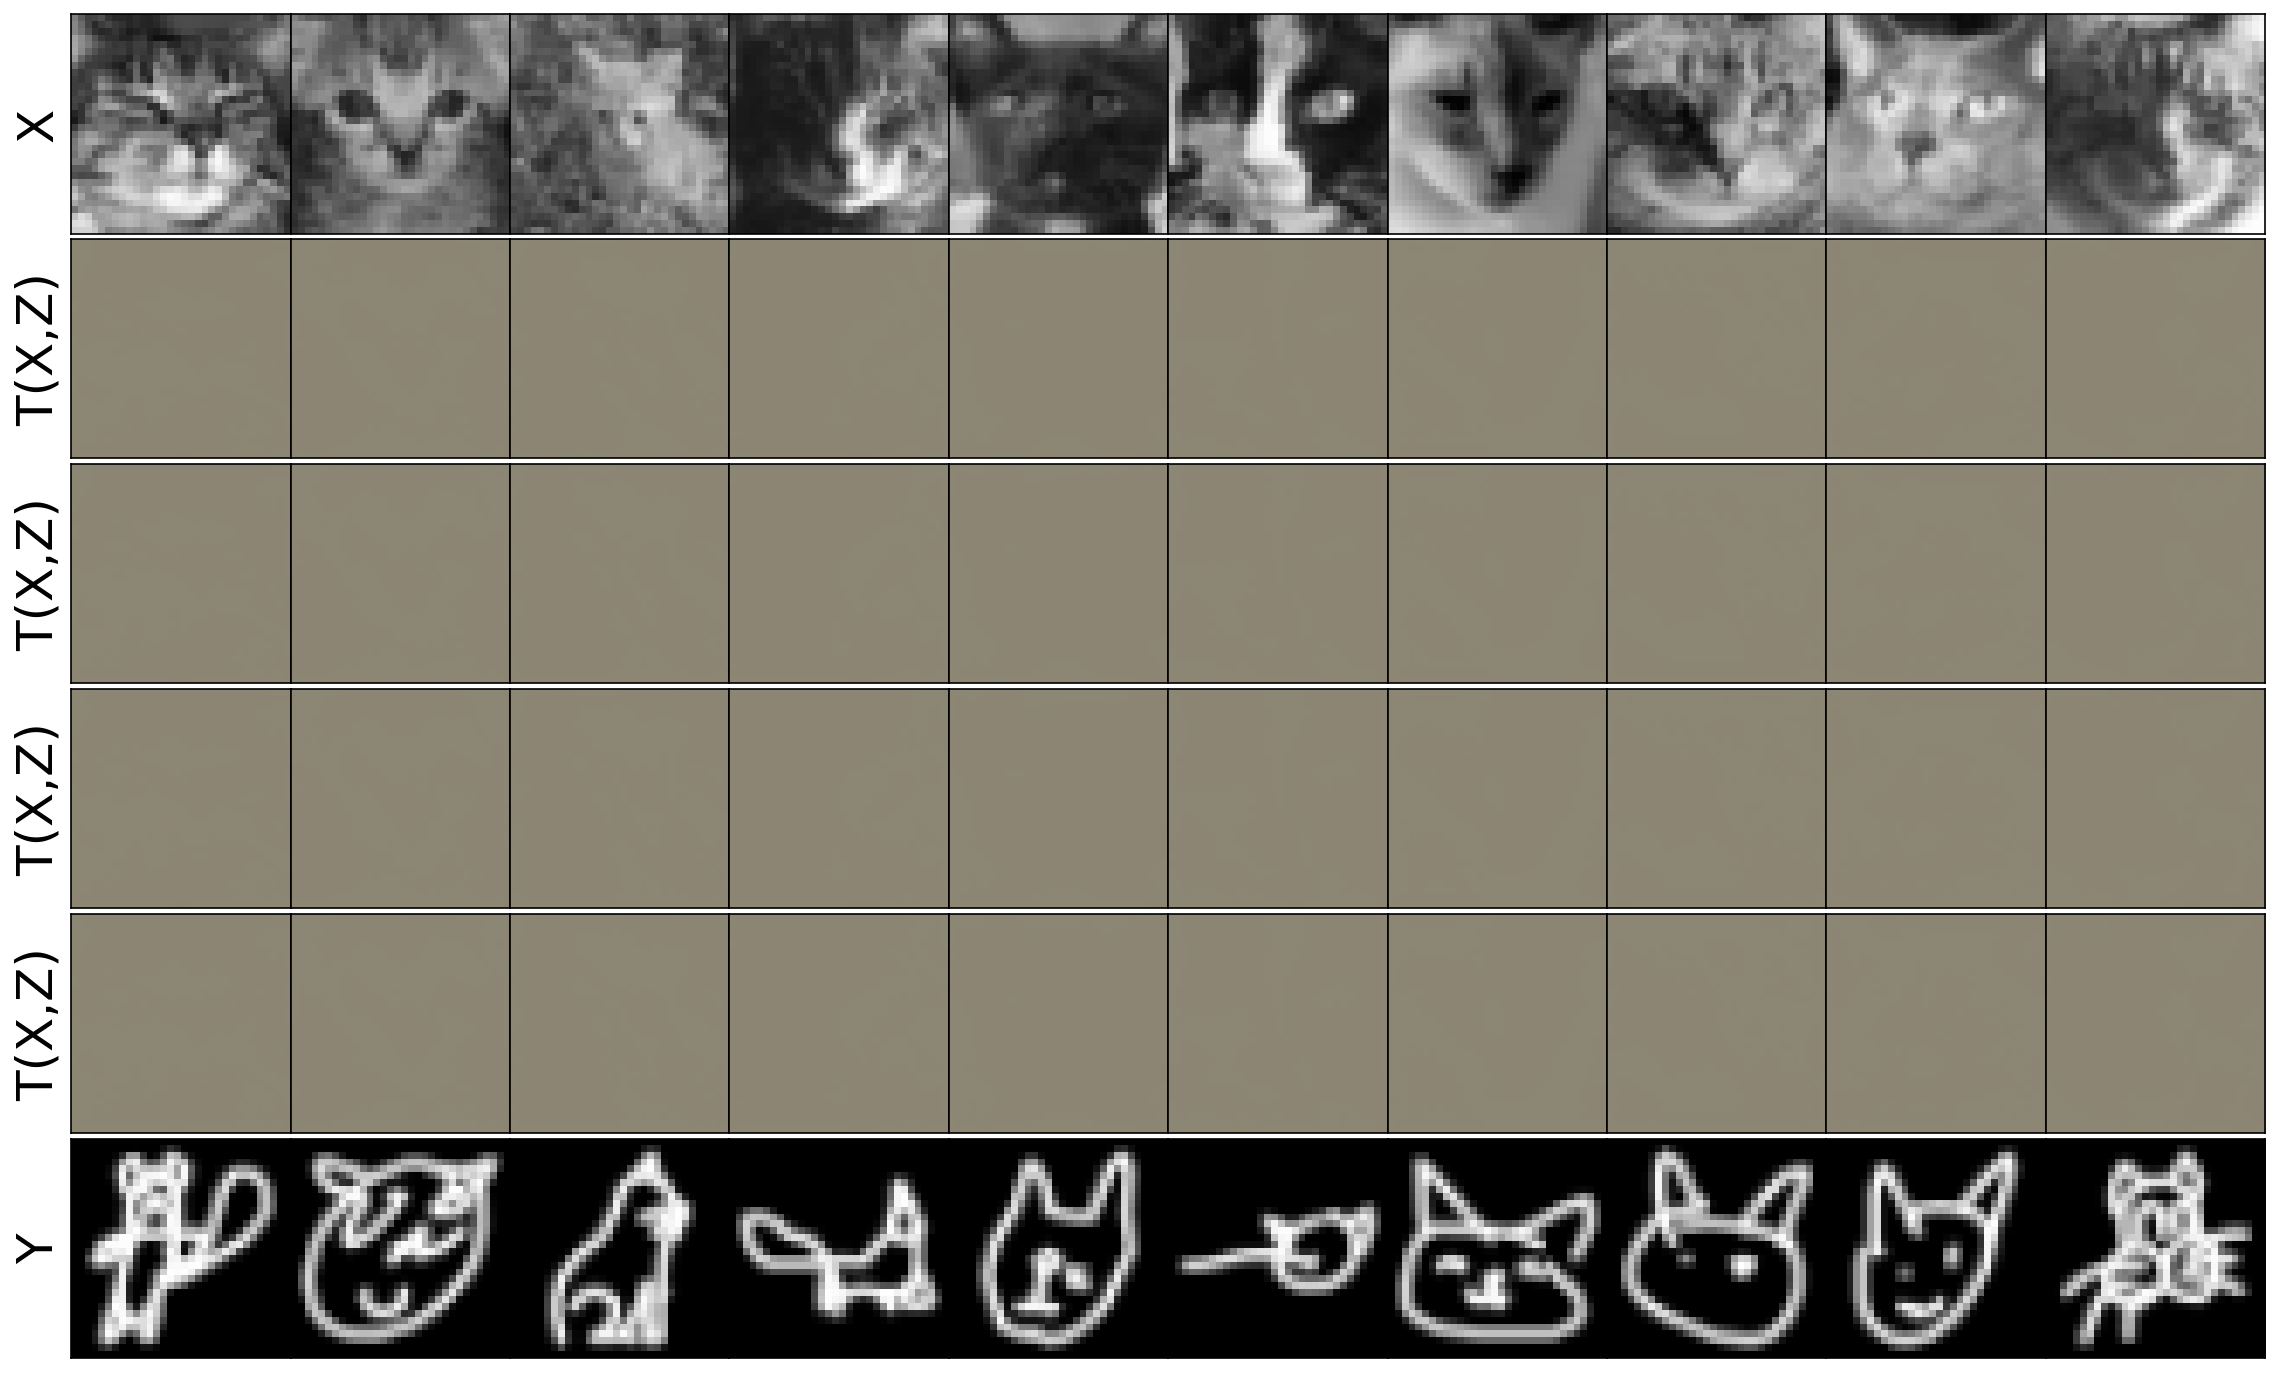

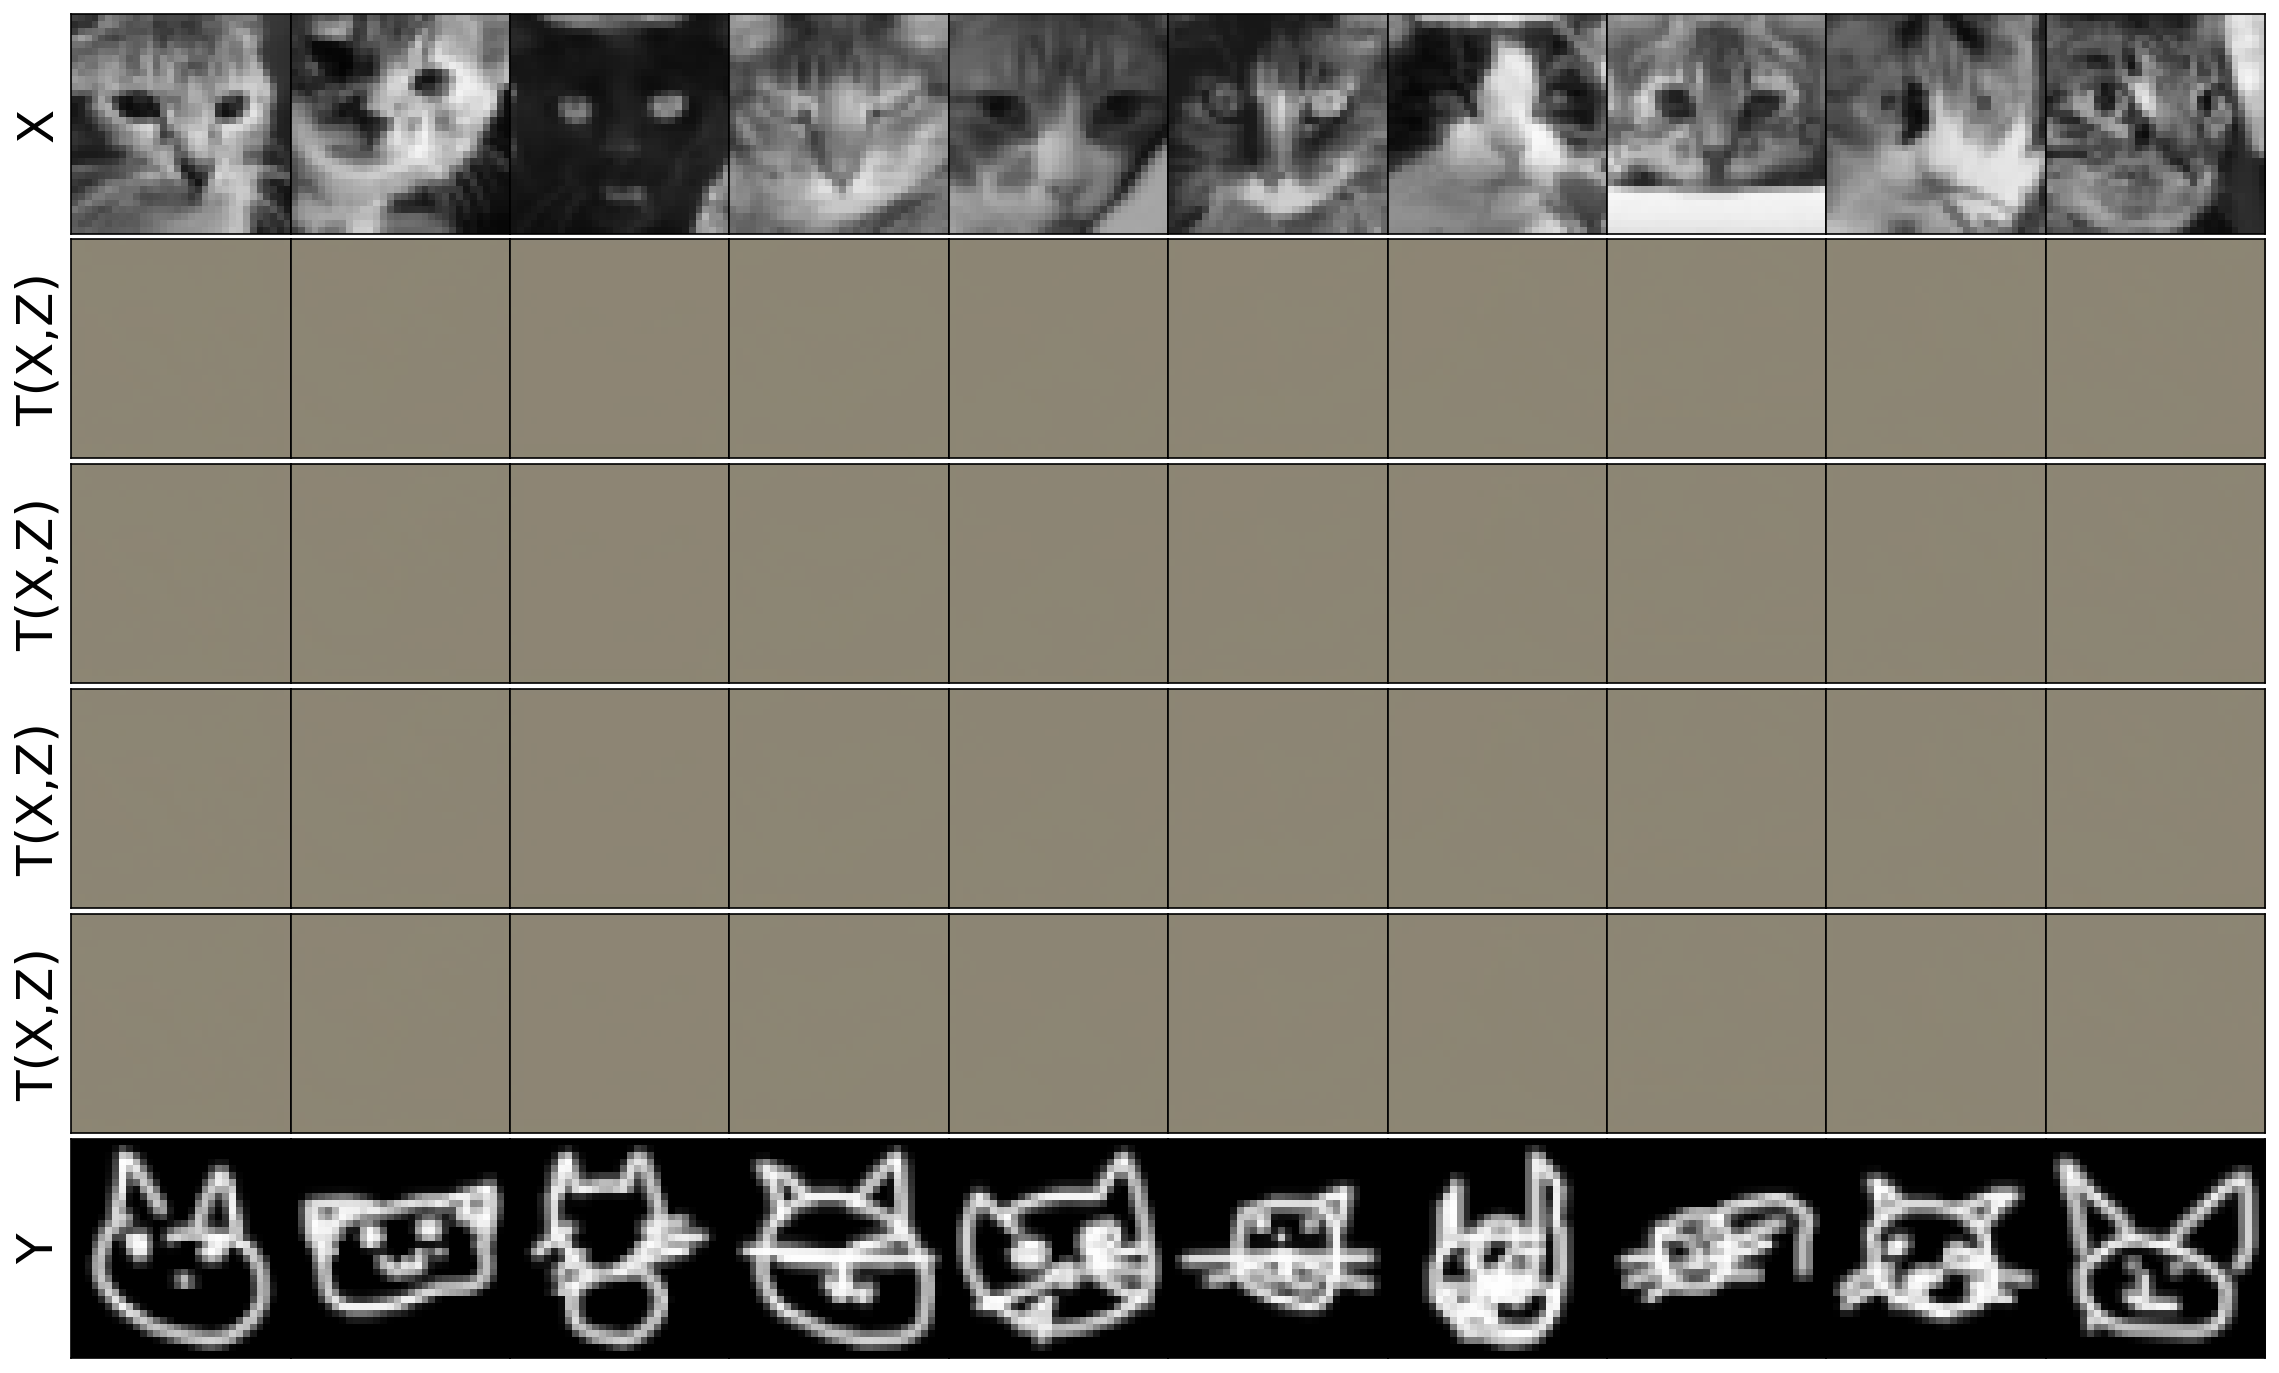

In [13]:
fig, axes = plot_Z_images(XZ_fixed, Y_fixed, T)
fig, axes = plot_random_Z_images(X_sampler, ZC, Z_STD, Y_sampler, T)
fig, axes = plot_Z_images(XZ_test_fixed, Y_test_fixed, T)
fig, axes = plot_random_Z_images(X_test_sampler, ZC, Z_STD, Y_test_sampler, T)

In [14]:
wandb.init(name=EXP_NAME, project='style_transfert', entity='danymost04-cole-normale-sup-rieure-paris-saclay', config=config)
pass

In [15]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

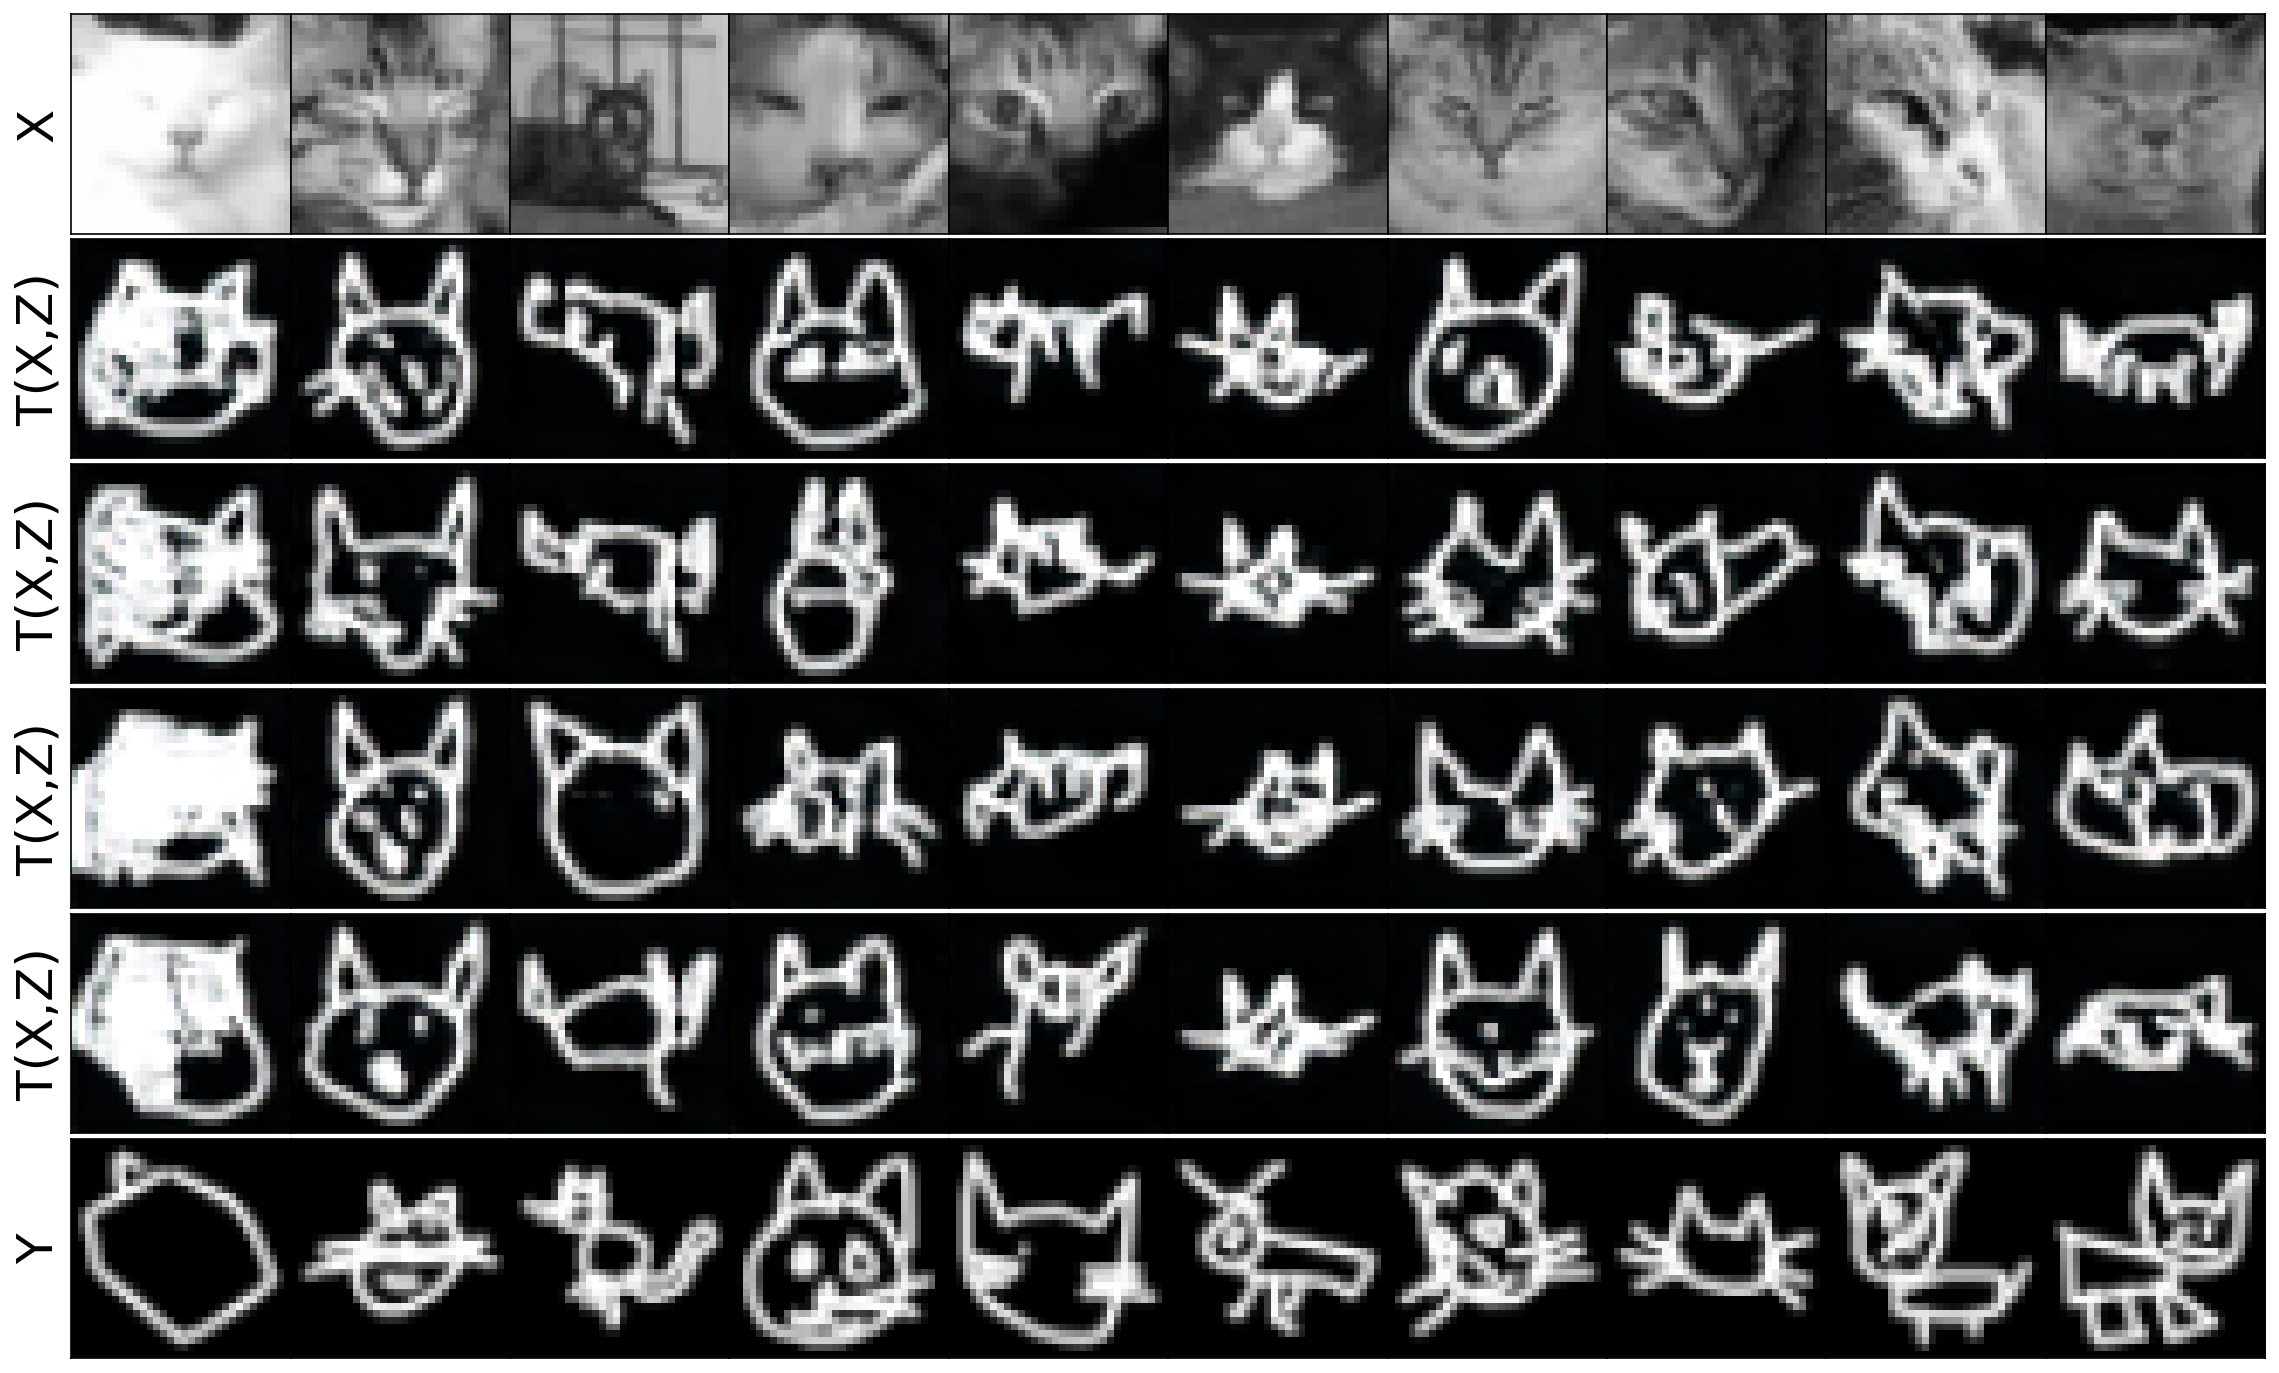

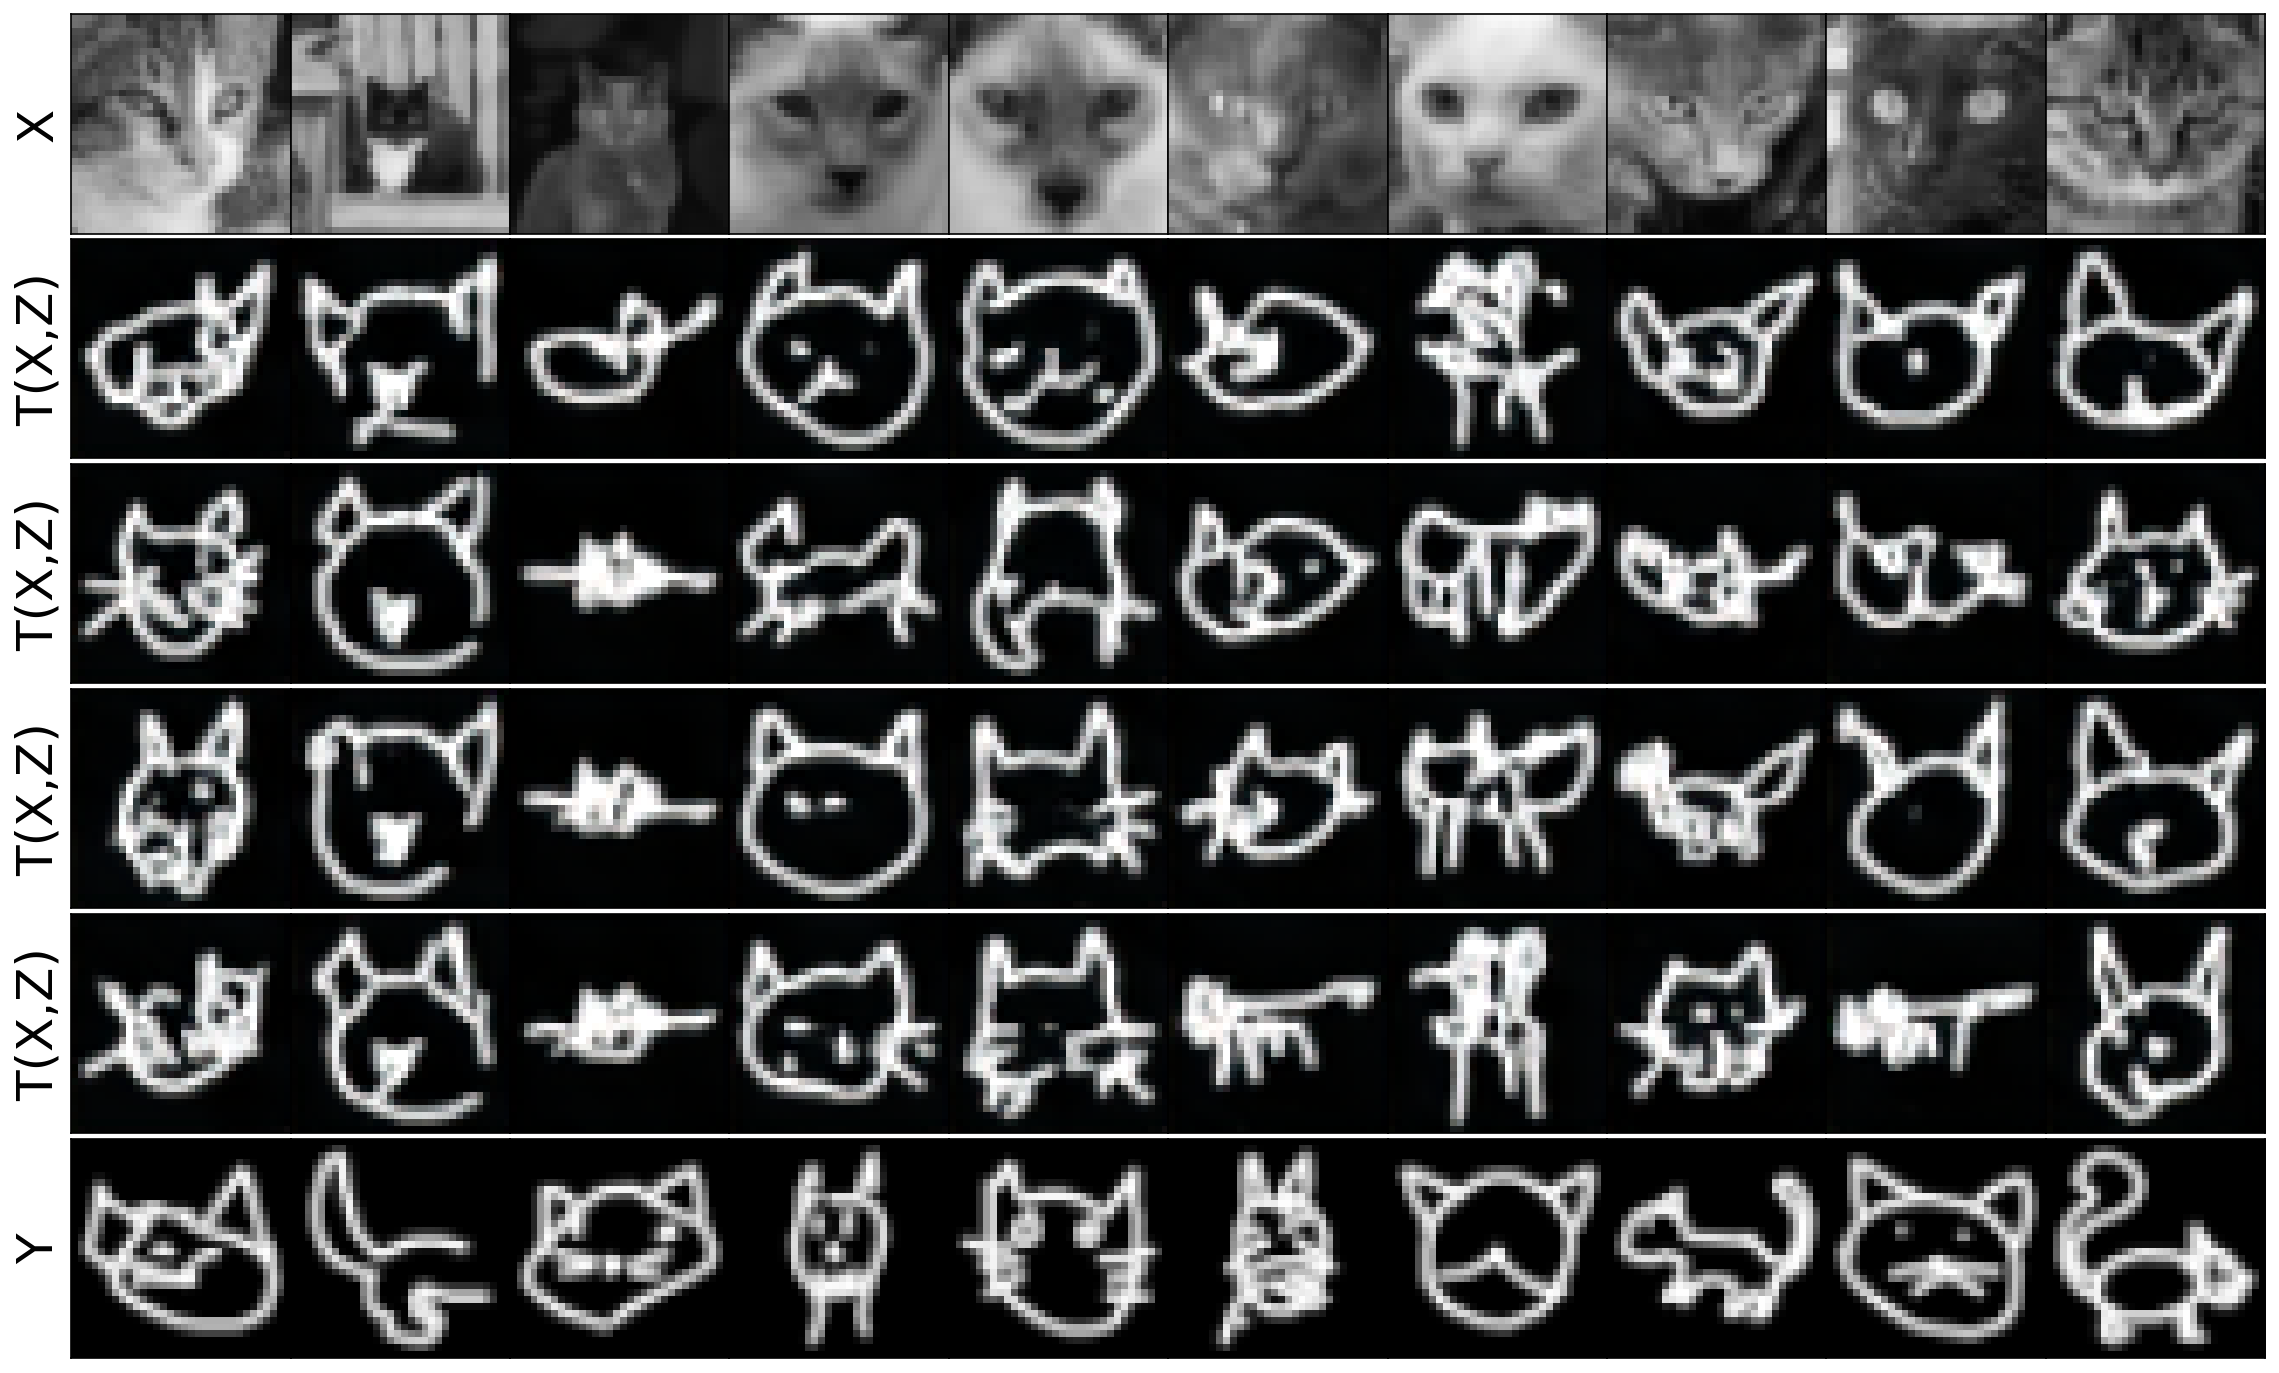

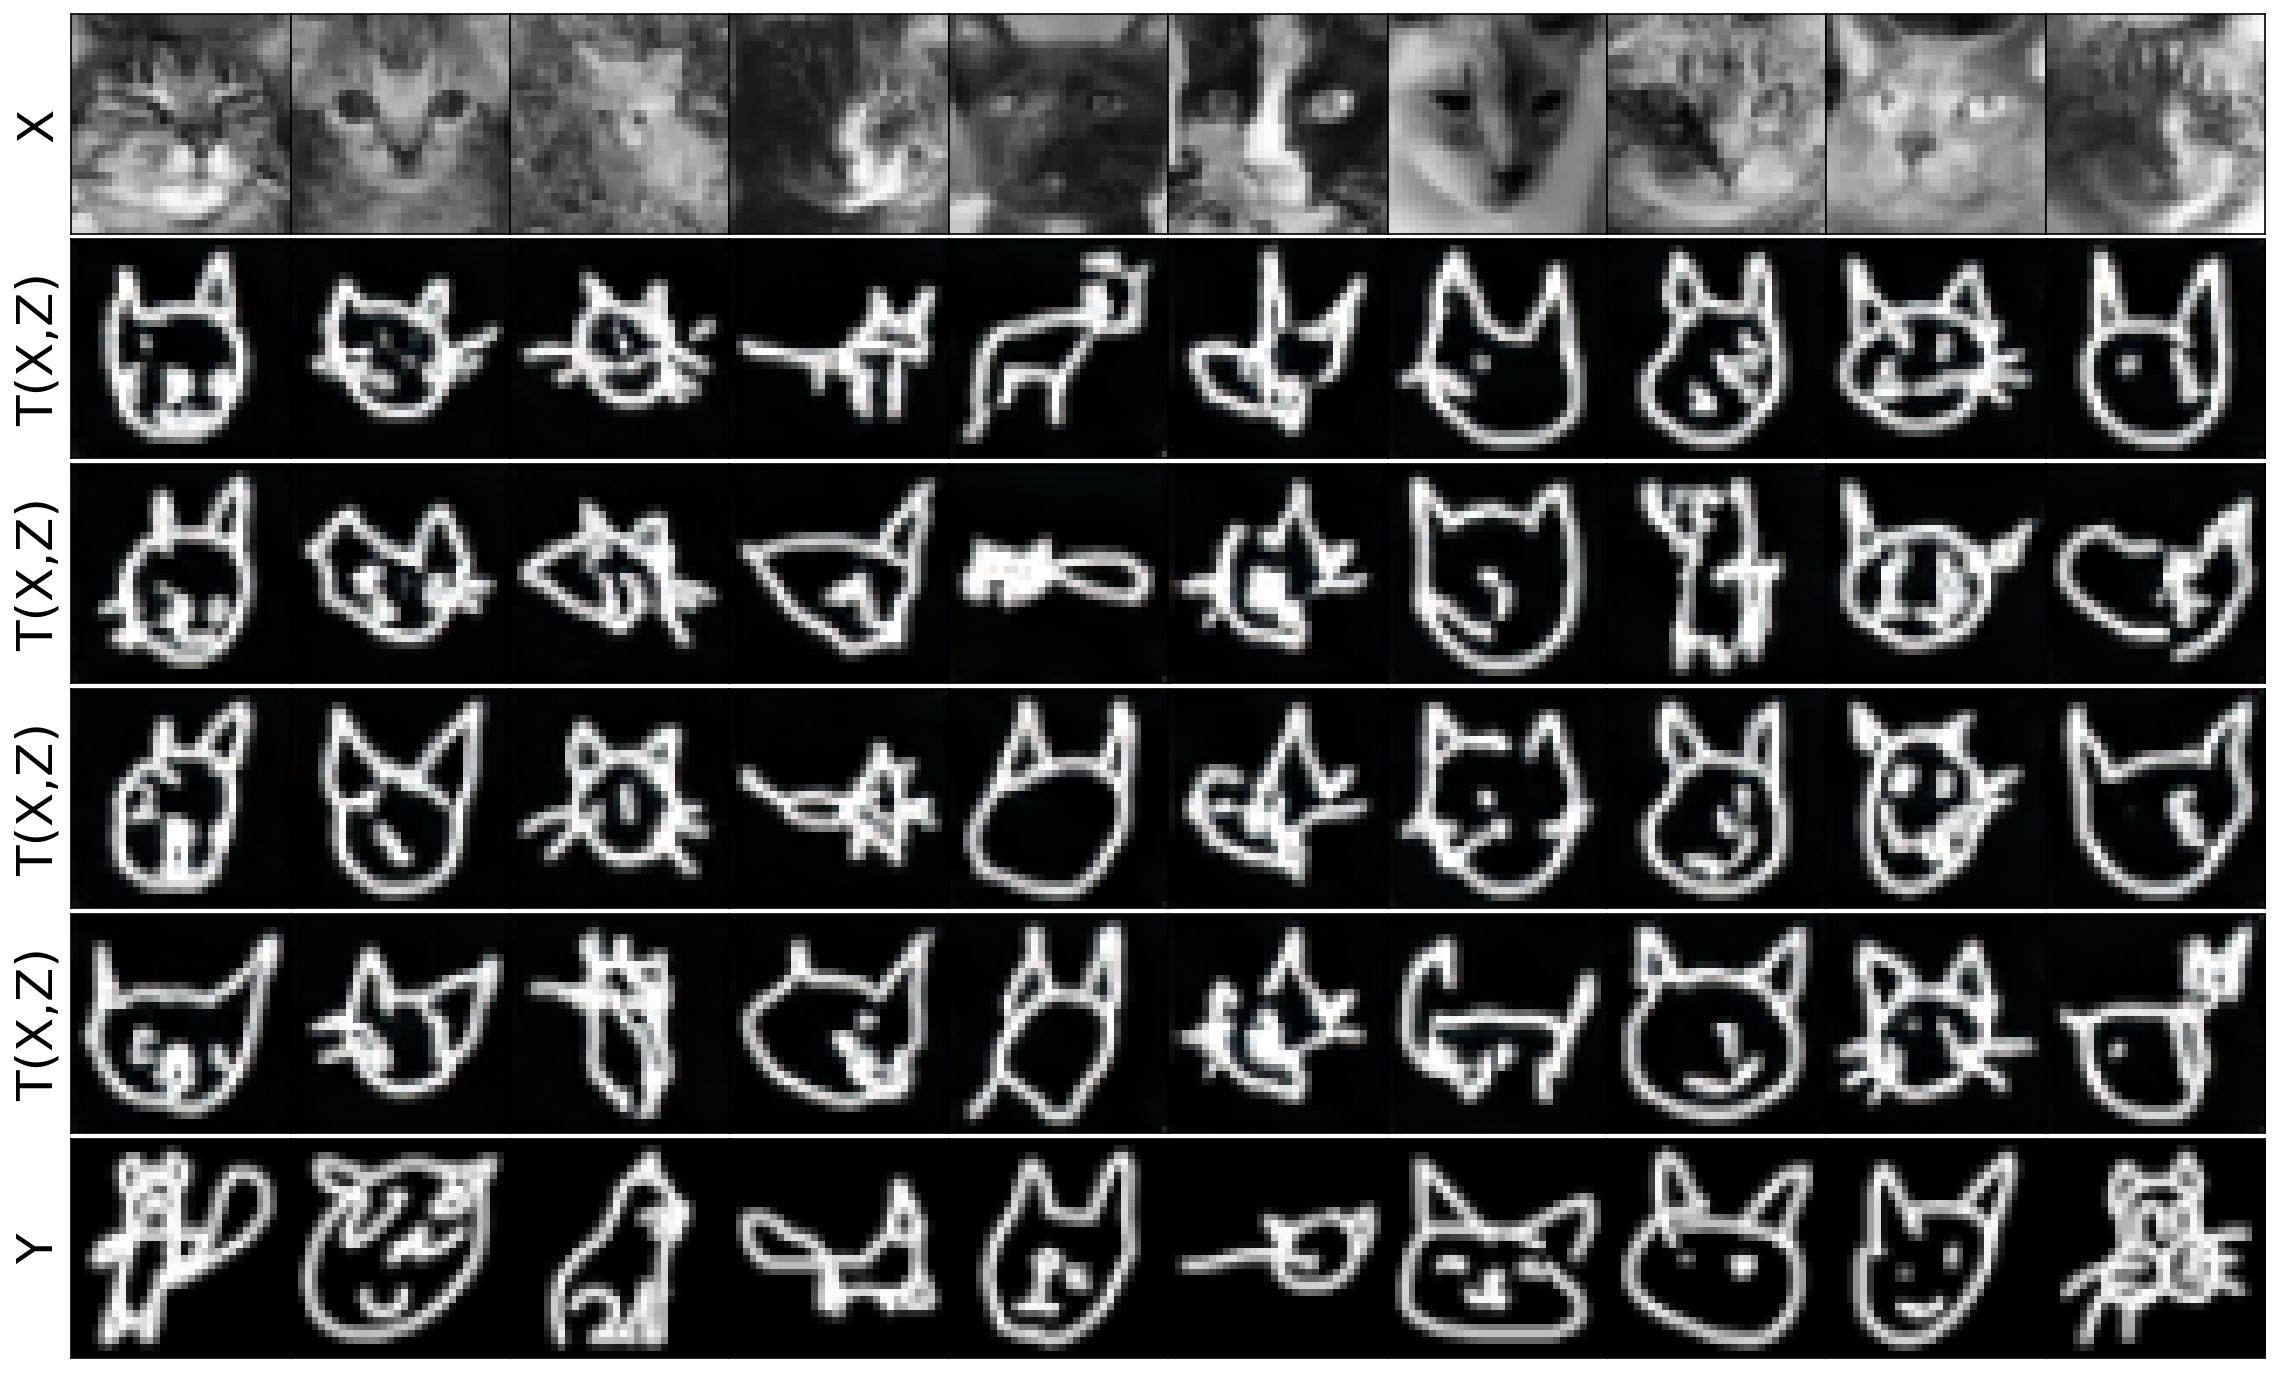

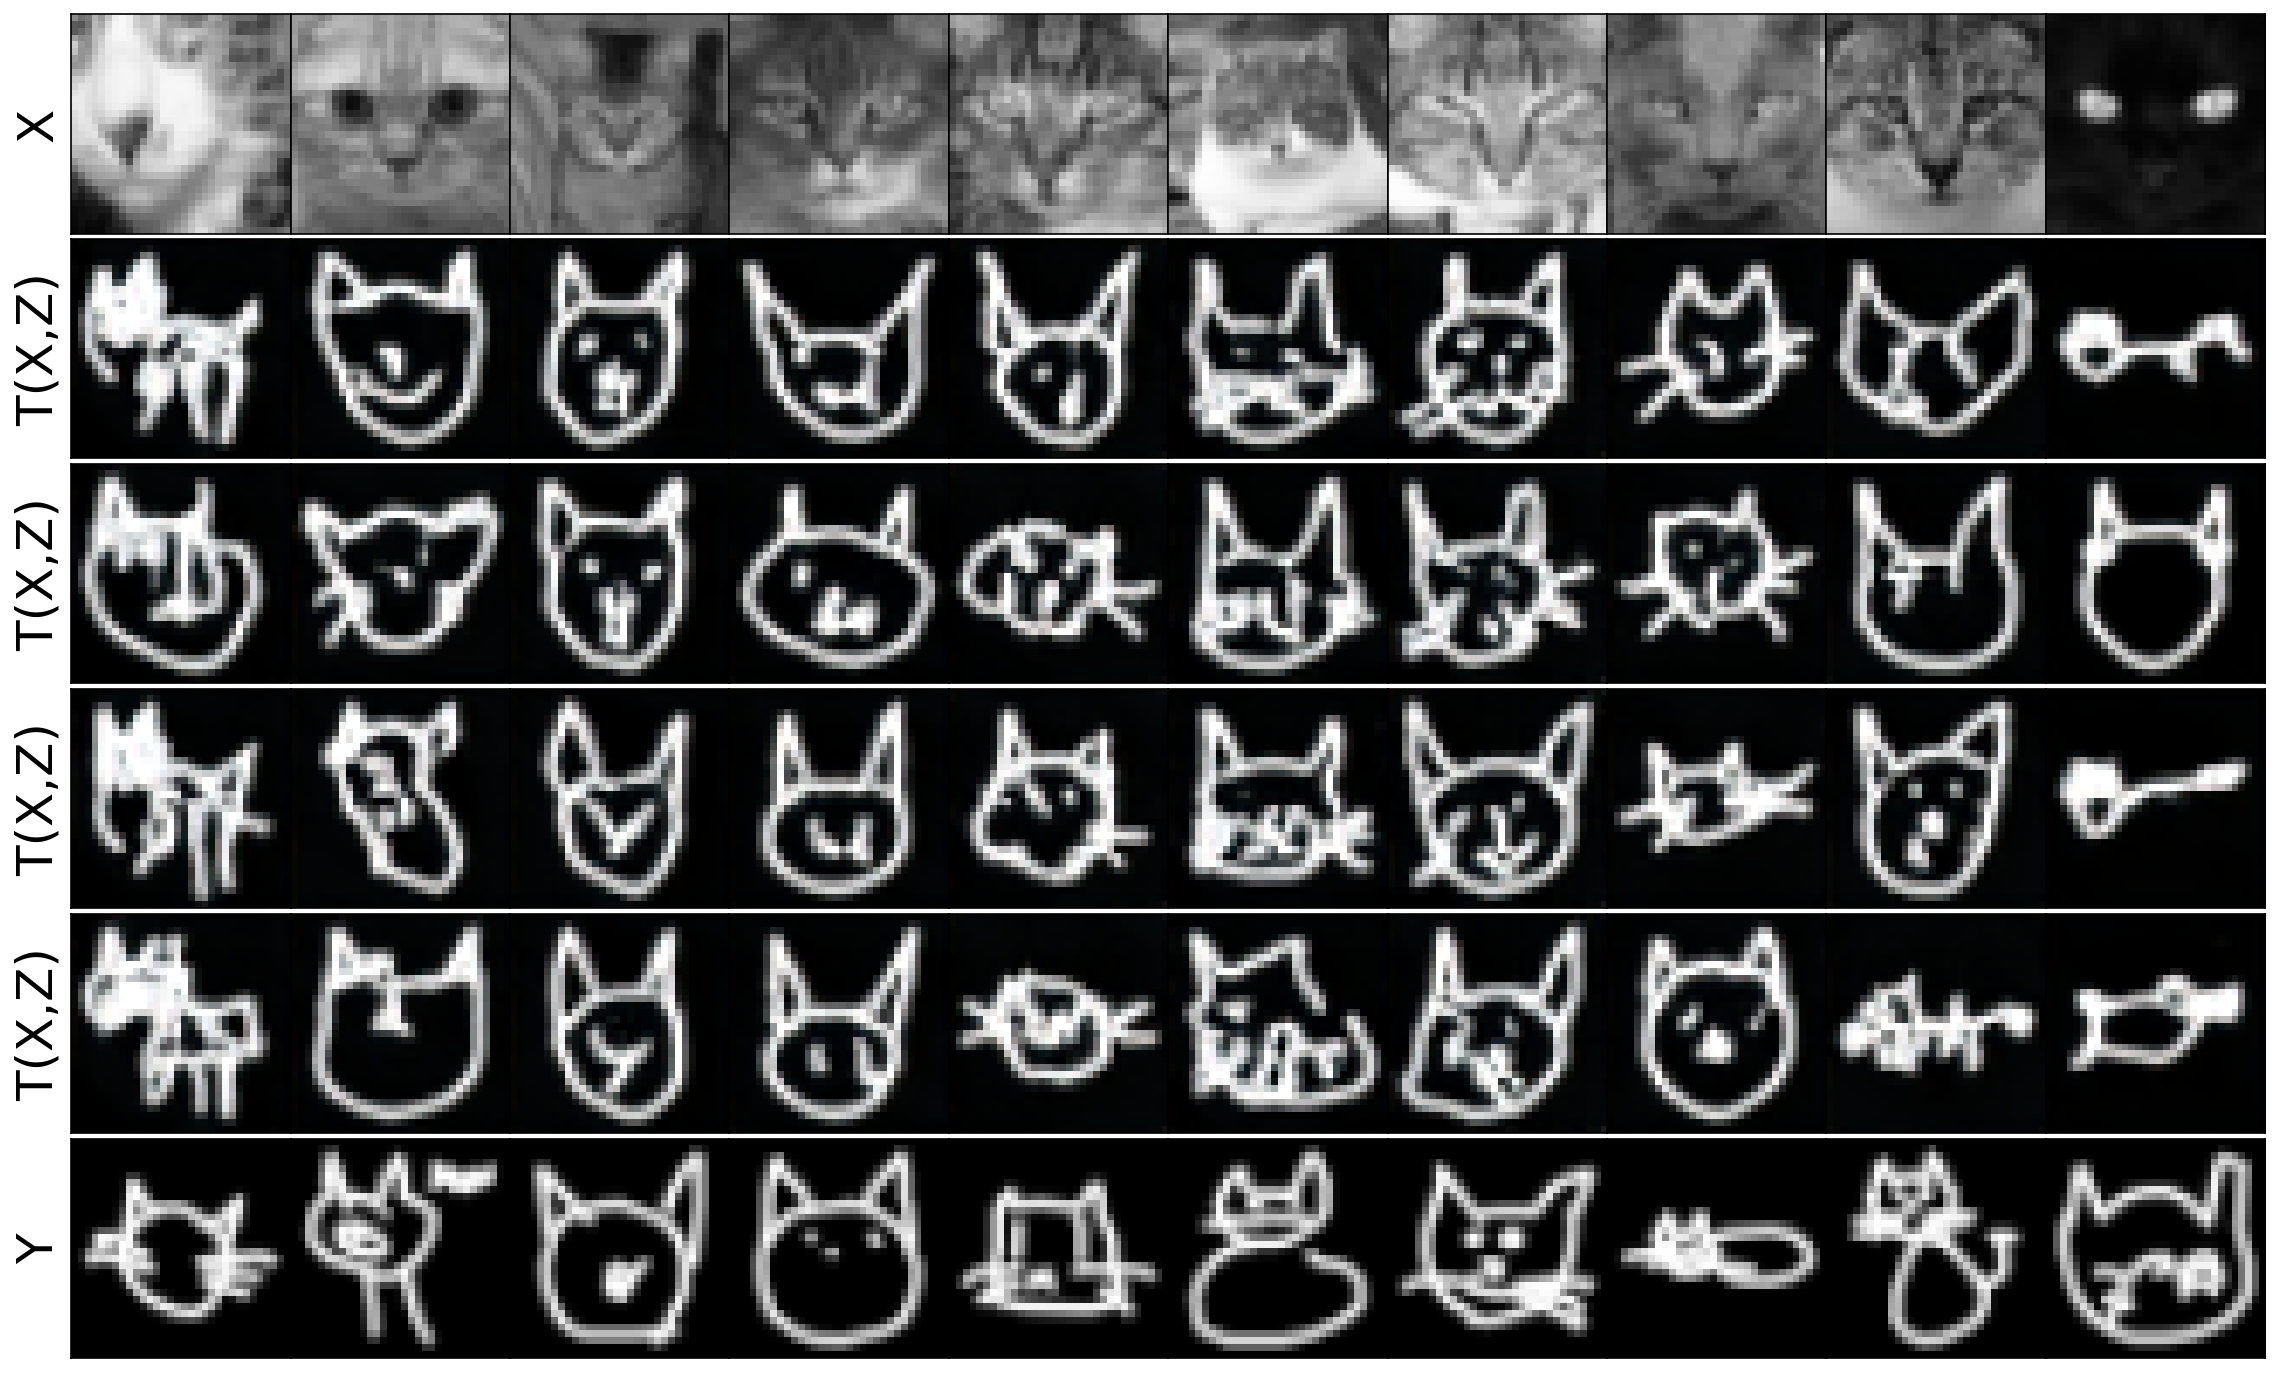

In [16]:
for step in tqdm(range(MAX_STEPS)):
    gamma = min(GAMMA1, GAMMA0 + (GAMMA1-GAMMA0) * step / GAMMA_ITERS)
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)[:,None].repeat(1,Z_SIZE,1,1,1)
        with torch.no_grad():
            Z = torch.randn(BATCH_SIZE, Z_SIZE, ZC, IMG_SIZE, IMG_SIZE, device='cuda') * Z_STD
            XZ = torch.cat([X, Z], dim=2)
        T_XZ = T(
            XZ.flatten(start_dim=0, end_dim=1)
        ).permute(1,2,3,0).reshape(3, IMG_SIZE, IMG_SIZE, -1, Z_SIZE).permute(3,4,0,1,2)
        
        T_loss = F.mse_loss(X[:,0], T_XZ.mean(dim=1)).mean() - \
        f(T_XZ.flatten(start_dim=0, end_dim=1)).mean() + \
        T_XZ.var(dim=1).mean() * (1 - gamma - 1. / Z_SIZE)
        
        T_loss.backward(); T_opt.step()
    del T_loss, T_XZ, X, Z; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        Z = torch.randn(BATCH_SIZE, ZC, X.size(2), X.size(3), device='cuda') * Z_STD
        XZ = torch.cat([X,Z], dim=1)
        T_XZ = T(XZ)
    Y = Y_sampler.sample(BATCH_SIZE)
    f_opt.zero_grad()
    f_loss = f(T_XZ).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step();
    wandb.log({f'f_loss' : f_loss.item()}, step=step)
    del f_loss, Y, X, T_XZ, Z, XZ; gc.collect(); torch.cuda.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_Z_images(XZ_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_Z_images(X_sampler, ZC, Z_STD,  Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_Z_images(XZ_test_fixed, Y_test_fixed, T)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_Z_images(X_test_sampler, ZC, Z_STD,  Y_test_sampler, T)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig)
        torch.save(T.state_dict(), f"./{OUTPUT_PATH}/T_{step}.pth")
        torch.save(f.state_dict(), f"./{OUTPUT_PATH}/f_{step}.pth")
    gc.collect(); torch.cuda.empty_cache()